# <center>Przewidywanie rezygnacji z konta bankowego</center>
---
### <center>https://www.kaggle.com/datasets/shrutimechlearn/churn-modelling/data</center>  
---

Zbiór ten zawiera dane dotyczące klientów banku, a zmienną docelową jest zmienna binarna **Exited** odzwierciedlająca fakt, czy klient opuścił bank (zamknął konto), czy też nadal jest klientem.  

---

[1. PRZYGOTOWANIE I SPRAWDZENIE POPRAWNOŚCI OTRZYMANYCH DANYCH.](#R1)
- [Opis danych](#R1.1)  

[2. ANALIZA DANYCH:](#R2)
- [2.1. Variable Exited - zmienna objaśniana](#R2.1)
- [2.2. Variable Geography](#R2.2)
- [2.3. Variable CreditScore](#R2.3)
- [2.4. Variable Gender](#R2.4)
- [2.5. Variable Age](#R2.5)
- [2.6. Variable Tenure](#R2.6)
- [2.7. Variable Balance](#R2.7)
- [2.8. Variable NumOfProduct](#R2.8)
- [2.9. Variable EstimatedSalary](#R2.9)
- [2.10. Variable HasCrCard](#R2.10)
- [2.11. Variable IsActiveMember](#R2.11)

[3. PRZYGOTOWANIE DANYCH:](#R3)
- [3.1. Variable Age](#R3.1)
- [3.2. Variable CreditScore](#R3.2)
- [3.3. Variable EstimatedSalary](#R3.3)
- [3.4. Variable Balance](#R3.4)
- [3.5. Przygotowanie danych dla modeli](#R3.5)

[4. MODELE MATEMATYCZNE:](#R4)
- [4.1. Sprawdzenie dokładności przewidywania na różnych typach modeli w oparciu o dane z Niemiec - model RandomForestClassifier](#R4.1)
- [4.2. Sprawdzenie dokładności przewidywania na różnych typach modeli w oparciu o wszystkie dane - model RandomForestClassifier](#R4.2)
- [4.3. Zwiększenie liczebności zmiennej Exited - oversampling SMOTE](#R4.3)
- [4.4. Wykorzystanie biblioteki Tensorflow do budowania modelu](#R4.4)

[5. WNIOSKI](#R5) 

### <a id = "R1">1. PRZYGOTOWANIE I SPRAWDZENIE POPRAWNOŚCI OTRZYMANYCH DANYCH.</a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
from scipy.stats import chi2_contingency, spearmanr, normaltest, boxcox, probplot

In [4]:
def check_normal_distr(df, column, explained):
    '''
    Funkcja zwraca informacje na temat rozkładu zmiennych i ich korelacji
    df: Dataframe z danymi
    column: kolumna z danymi
    explained: zmienna objaśniana
    '''
    chi2, p, dof, expected = chi2_contingency(pd.crosstab(df[column], df[explained]))
    k2, p_normal = normaltest(df[column])
    if p_normal>0.05:
        temp_ = f'Zmienna {column} posiada rozkład normalny'
    else:
        temp_ = f'Zmienna {column} NIE posiada rozkładu normalnego'
    print(column)
    print(f'Skośność: {df[column].skew()}, kurtoza: {df[column].kurtosis()}')
    print('Statistic=%.3f, p=%.3f, dof=%.3f' % (chi2, p, dof))
    print('p_normal=%.3f - %s' % (p_normal, temp_))

In [5]:
def drop_outliers(df, column):
    '''
    Funkcja zwraca tablicę z danymi z oczyszczonej ramki z wartości odstających 
    df: Dataframe z danymi
    column: seria danych do sprawdzenia wartości odstających
    '''
    df_temp = df[((df[column]>(df[column].mean()+3*df[column].std())) | (df[column]<(df[column].mean()-3*df[column].std())))]
    return df[column].drop(list(df_temp.index), axis=0).values

In [6]:
def show_outliers(df, column):
    '''
    Funkcja zwraca dataframe z danymi odstającymi 
    df: Dataframe z danymi
    column: seria danych do sprawdzenia wartości odstających
    '''
    df_temp = df[((df[column]>(df[column].mean()+3*df[column].std())) | (df[column]<(df[column].mean()-3*df[column].std())))]
    return df_temp

In [20]:
df = pd.read_csv('Churn_Modelling.csv')

In [21]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [22]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,NaN,NaN,NaN,5000.5,2886.89568,1.0,2500.75,5000.5,7500.25,10000.0
CustomerId,10000.0,NaN,NaN,NaN,15690940.5694,71936.186123,15565701.0,15628528.25,15690738.0,15753233.75,15815690.0
Surname,10000,2932,Smith,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CreditScore,10000.0,NaN,NaN,NaN,650.5288,96.653299,350.0,584.0,652.0,718.0,850.0
Geography,10000,3,France,5014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,10000,2,Male,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,10000.0,NaN,NaN,NaN,38.9218,10.487806,18.0,32.0,37.0,44.0,92.0
Tenure,10000.0,NaN,NaN,NaN,5.0128,2.892174,0.0,3.0,5.0,7.0,10.0
Balance,10000.0,NaN,NaN,NaN,76485.889288,62397.405202,0.0,0.0,97198.54,127644.24,250898.09
NumOfProducts,10000.0,NaN,NaN,NaN,1.5302,0.581654,1.0,1.0,1.0,2.0,4.0


### <a id = "R1.1"><center>Opis analizowanych danych</center></a>
<table>
    <tr><td><b>Oznaczenie danych</b></td><td><center><b>Opis zmiennej</b></center></td><td><center><b>Typ zmiennej</b></center></td></tr>
    <tr><td><b><font color="blue">RowNumber</font></b></td><td>Liczba porządkowa w bazie danych</td><td>Unikalny identyfikator każdego rekordu - nie ma wpływu na analizy.</td></tr>
    <tr><td><b><font color="blue">CustomerId</font></b></td><td>Numer klienta w banku</td><td>Unikalny identyfikator każdego rekordu - nie ma wpływu na analizy.</td></tr>
    <tr><td><b><font color="blue">Surname</font></b></td><td>Nazwisko klienta</td><td>Wartość tekstowa - nie ma wpływu na analizy.</td></tr>
    <tr><td><b><font color="blue">Tenure</font></b></td><td>Liczba lat, przez które klient jest związany z bankiem</td><td>Wartość liczbowa / kategoryczna</td></tr>
    <tr><td><b><font color="blue">Balance</font></b></td><td>Saldo bankowe klienta</td><td>Wartość liczbowa</td></tr>
    <tr><td><b><font color="blue">NumOfProducts</font></b></td><td>Liczba produktów bankowych, z których korzysta klient</td><td>Wartość liczbowa / kategoryczna</td></tr>
    <tr><td><b><font color="blue">CreditScore</font></b></td><td>Wskaźnik zdolności kredytowej klienta</td><td>Wartość liczbowa</td></tr>
    <tr><td><b><font color="blue">EstimatedSalary</font></b></td><td>Szacunkowe wynagrodzenie</td><td>Wartość liczbowa</td></tr>
    <tr><td><b><font color="blue">Geography</font></b></td><td>Kraj z którego pochodzi klient</td><td>Wartość tekstowa / kategoryczna</td></tr>
    <tr><td><b><font color="blue">Gender</font></b></td><td>Płeć klienta</td><td>Wartość liczbowa / kategoryczna</td></tr>
    <tr><td><b><font color="blue">Age</font></b></td><td>Wiek klienta</td><td>Wartość liczbowa (możemy spróbować ją traktować również jako kategoryczną).</td></tr>
    <tr><td><b><font color="blue">HasCrCard</font></b></td><td>Klient posiada kartę kredytową (0 - nie, 1 - tak)</td><td>Wartość liczbowa / kategoryczna</td></tr>
    <tr><td><b><font color="blue">IsActiveMember</font></b></td><td>Klient aktywnie korzysta z produktów bankowych (0 - nie, 1 - tak)</td><td>Wartość liczbowa / kategoryczna</td></tr>
    <tr><td><b><font color="blue">Exited</font></b></td><td> Zmienna objasniana - klient odszedł z banku (0 - nie, 1 - tak)</td><td>Wartość liczbowa / kategoryczn</td></tr>
</table> 

In [9]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

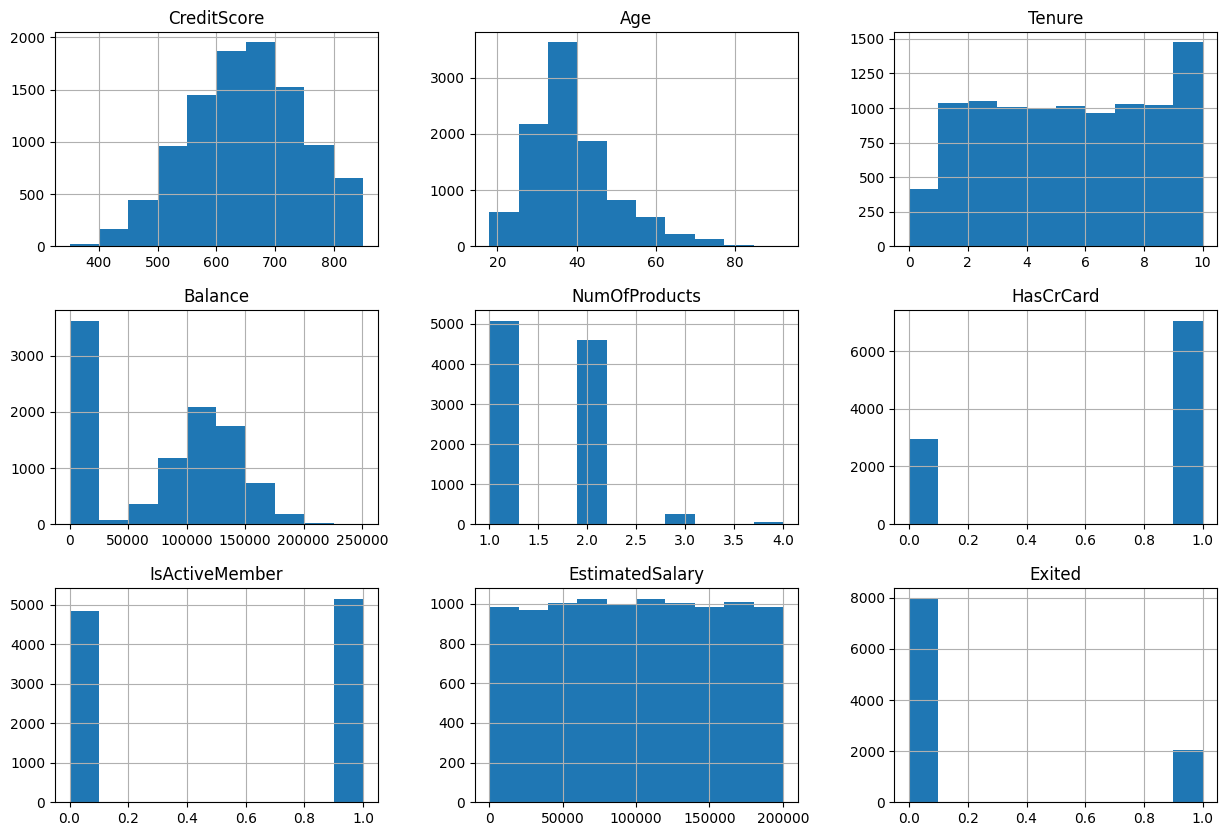

In [11]:
df.hist(figsize=(15,10))
plt.show()

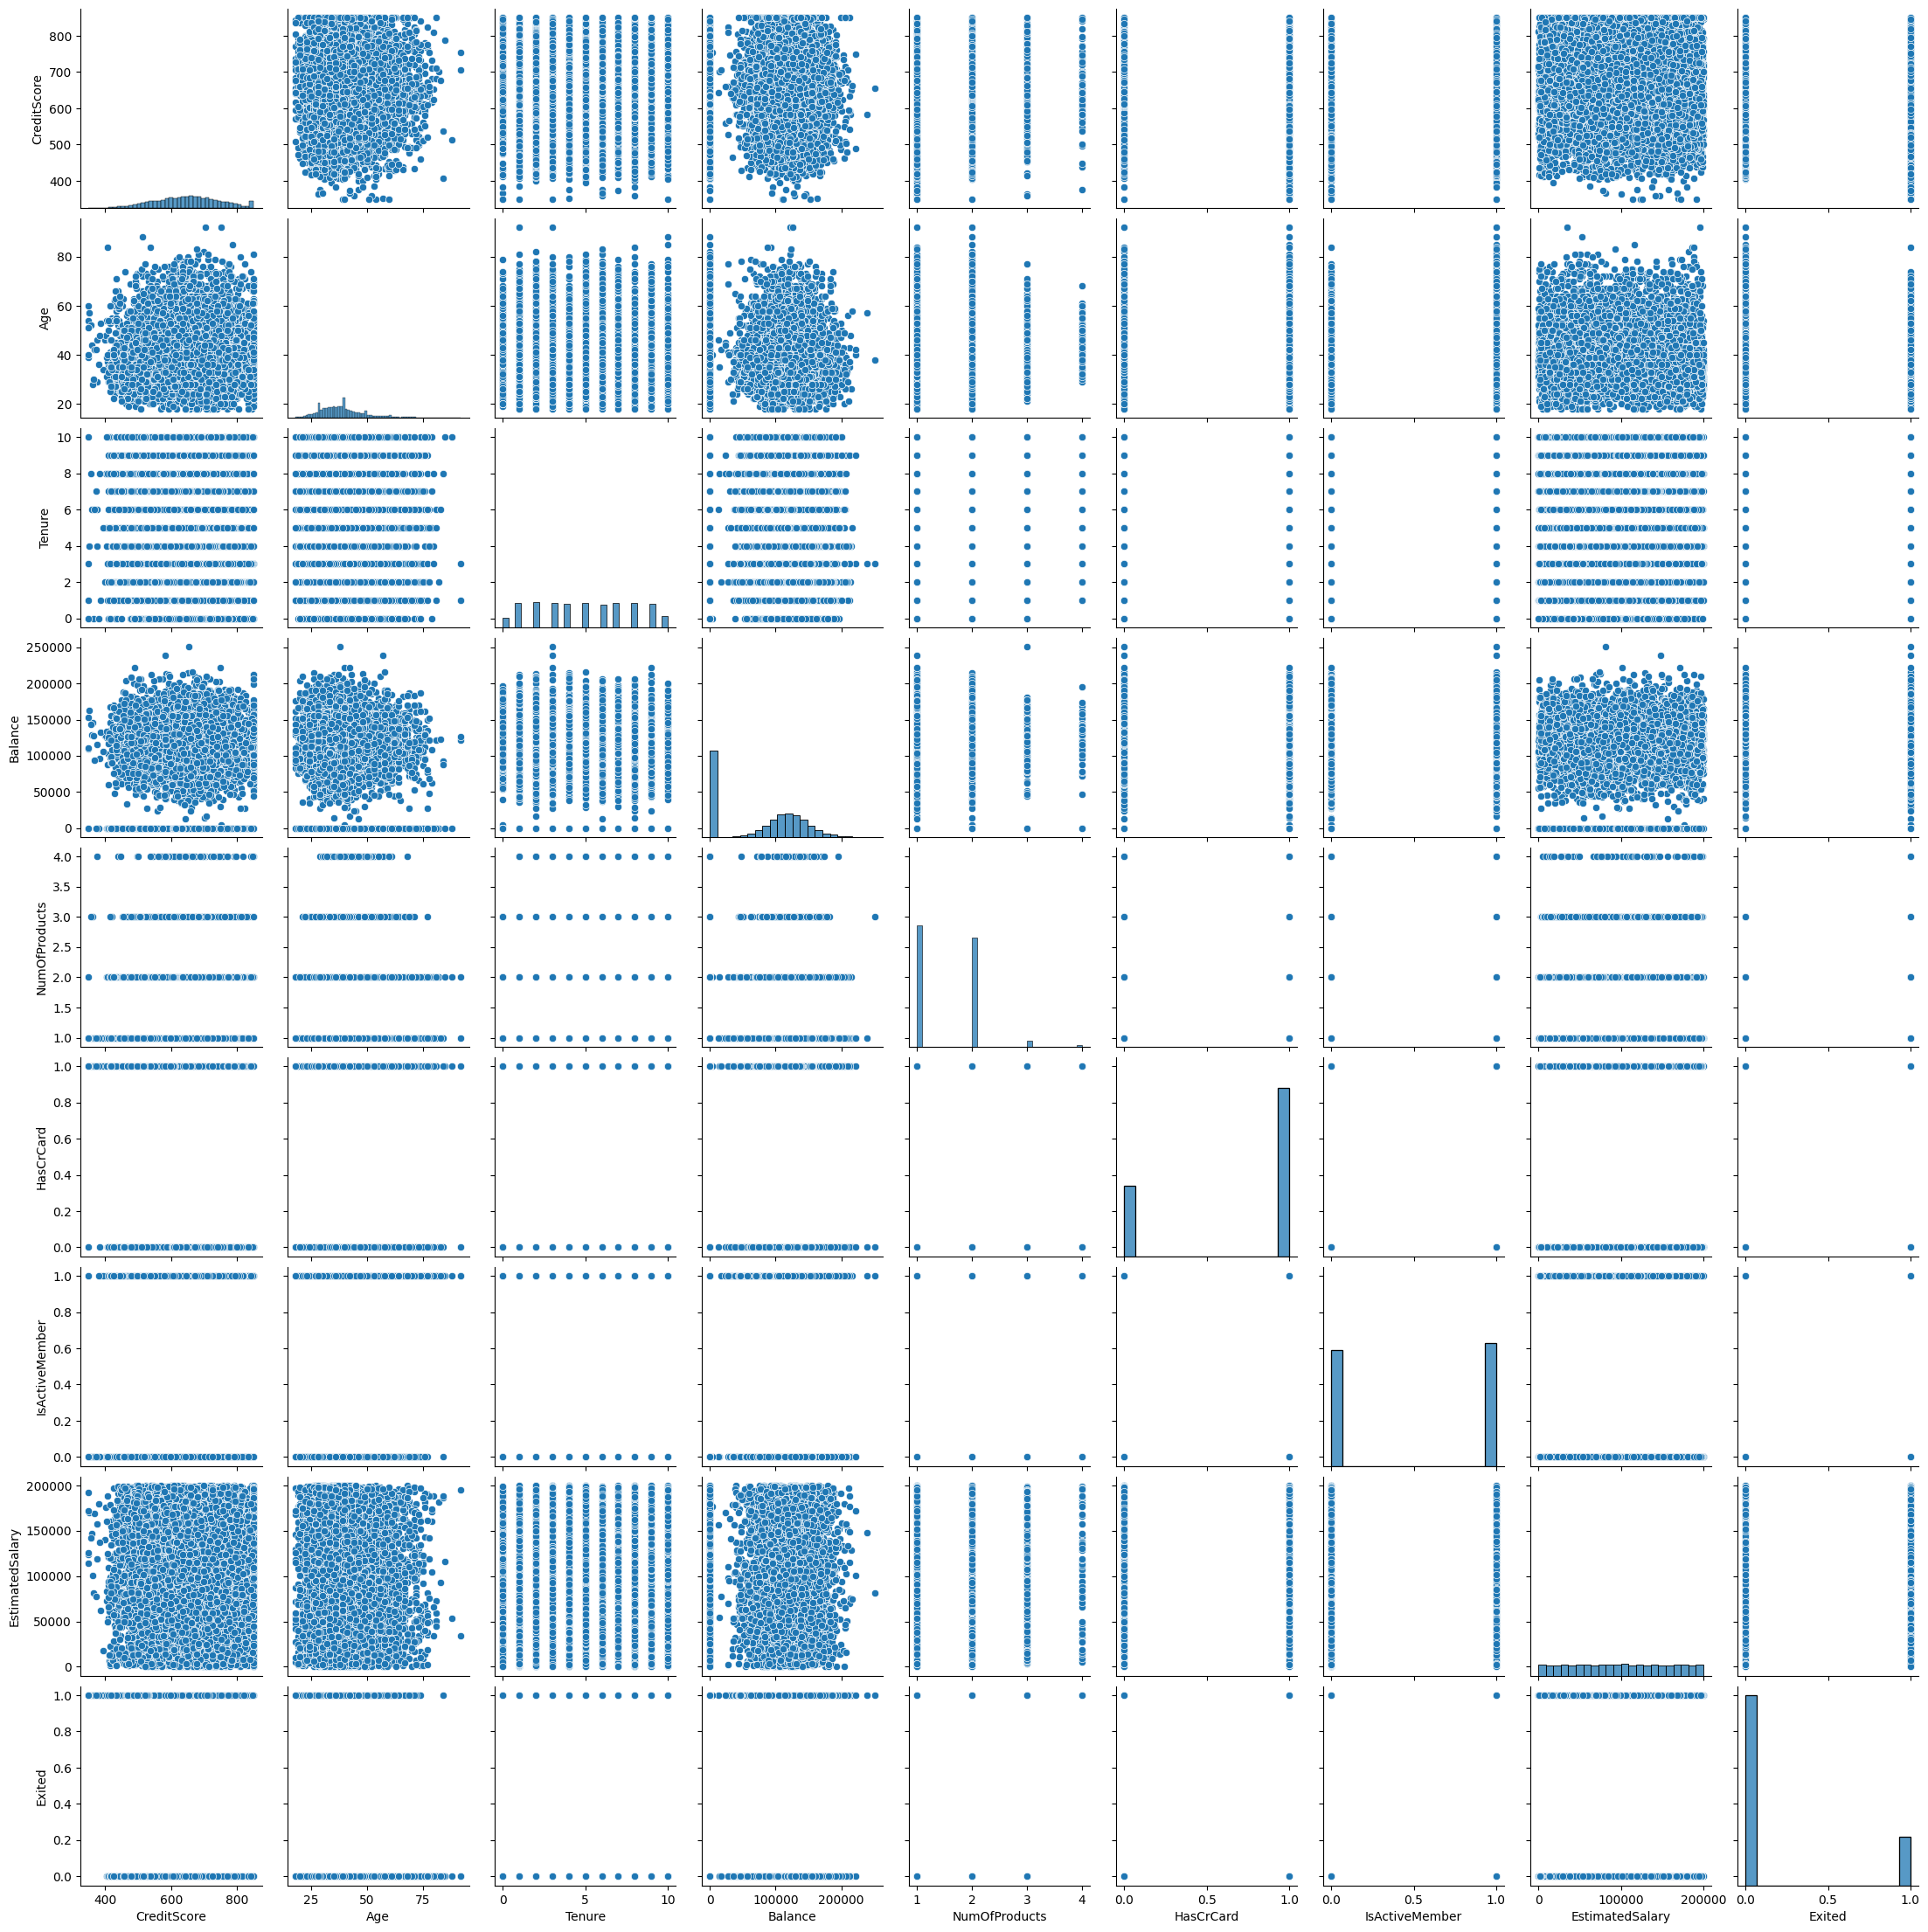

In [12]:
sns.pairplot(df)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


Wszystkie dane są uzupełnione, brak danych do uzupełnienia.  
Należy zwrócić uwagę czy wszystkie dane zawierają odpowiednie wartości.  

In [14]:
columns_continous = ['Age','CreditScore','Balance','EstimatedSalary']
columns_categorical = ['Geography','Gender','Tenure','NumOfProducts','HasCrCard','IsActiveMember']

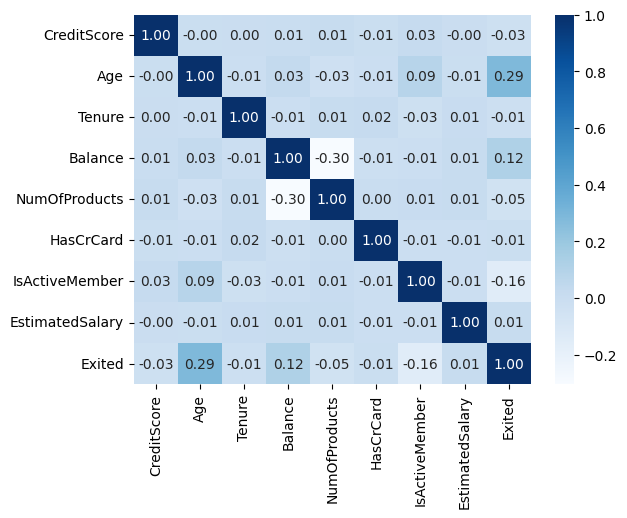

In [14]:
_ = sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='Blues', fmt='.2f')

Zmienna Balance jest słabo skorelowana ze zmienną NumOfProducts.  
Zmienna Exited jest słabo skorelowana ze zmienną Age.
Zmienne RowNumber, CustomerId i Surname nie mają wpływu na wartość objaśnianą, dlateg

## <a id = "R2">2. Analiza danych:</a>

### <a id = "R2.1">2.1. Variable Exited - zmienna objaśniana</a>

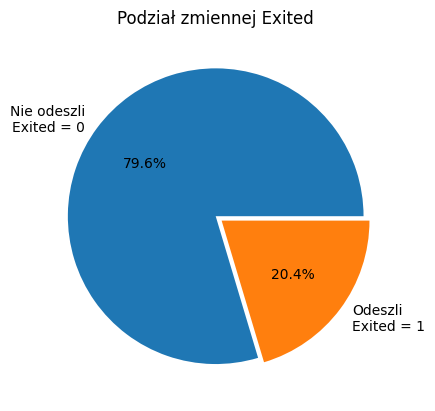

In [50]:
plt.pie(df.Exited.value_counts().values, labels=['Nie odeszli\nExited = 0','Odeszli\nExited = 1'], autopct="%1.1f%%",explode=[0,0.05])
plt.title('Podział zmiennej Exited')
plt.show()

Na 10.000 klientów pozyskanych przez bank 20.4% zdecydowało się na rezygnację z jego usług. 
Należy zauważyć dużą nierównowagę klas, która może prowadzić do trudności przy tworzeniu modelu.

### <a id = "R2.2">2.2. Variable Geography</a>

In [18]:
df.Geography.value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [812]:
pd.crosstab(df.Geography, df.Exited, margins=True, normalize='all').T*100

Geography,France,Germany,Spain,All
Exited,,,,
0,42.04,16.95,20.64,79.63
1,8.10,8.14,4.13,20.37
All,50.14,25.09,24.77,100.00


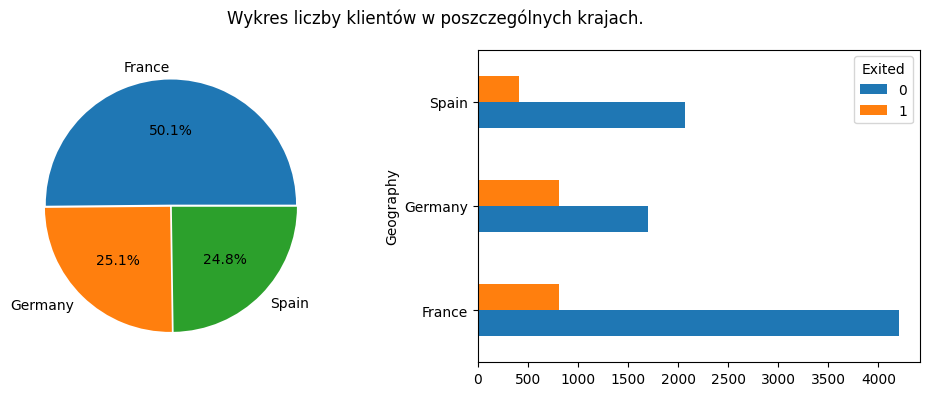

In [58]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

groupGeo = df.groupby(['Geography'])
labels = groupGeo.groups.keys()
sizes = groupGeo.size()

ax[0].pie(sizes, labels=labels, explode = [.01, .01, .01], autopct='%1.1f%%')

pd.crosstab(df['Geography'],df['Exited']).plot(kind='barh', ax=ax[1])
plt.suptitle('Wykres liczby klientów w poszczególnych krajach.')
fig.tight_layout()
plt.show()

Ponad 50% rekordów dotyczy klientów z Francji, Niemcy i Hiszpanie stanowią po ok. 25% zasobów. 
Spośród wszystkich klientów w 3 państwach największa liczba osób została utracona w Niemczech, bo aż 8.14%.  
Stanowi to 32.44% ogółu petentów w samych Niemczech i niespełna 40% wszystkich utraconych klientów we wszystkich państwach, co może wskazywać na mało atrakcyjną ofertę banku w tym kraju.  
Wartość ta przewyższa nawet odejścia usługobiorców we Francji, w której klientów jest ponad dwa razy więcej niż w Niemczech.

### <a id = "R2.3">2.3. Variable CreditScore</a>

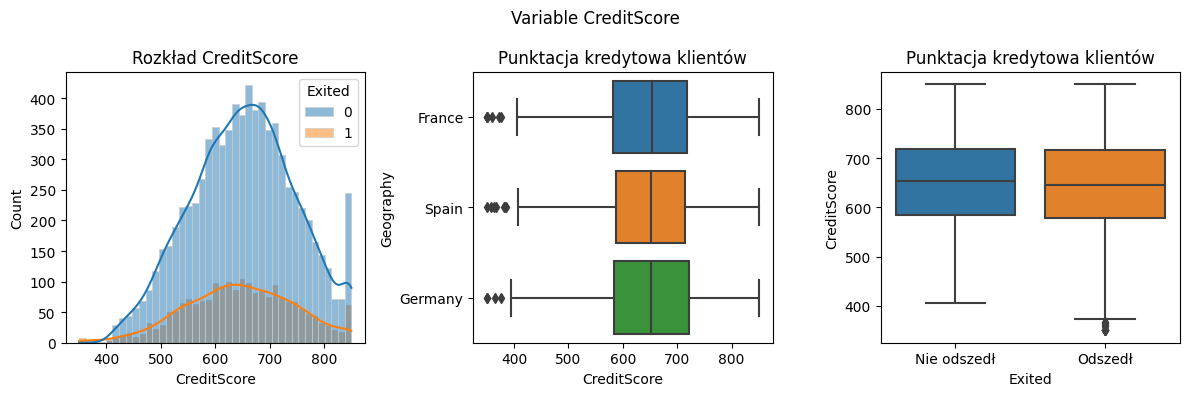

In [331]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

sns.histplot(
    df,
    x="CreditScore", 
    hue="Exited",
    multiple="layer",
    edgecolor=".8",
    linewidth=.5,
    kde=True,
    ax=ax[0]
)
ax[0].set_title('Rozkład CreditScore')

sns.boxplot(
    df,
    x="CreditScore", y="Geography",
    ax=ax[1]
)
ax[1].set_title('Punktacja kredytowa klientów')

sns.boxplot(
    df,
    x='Exited', y="CreditScore",
    ax=ax[2]
)
ax[2].set_title('Punktacja kredytowa klientów')
ax[2].set_xticklabels(['Nie odszedł','Odszedł'])
plt.suptitle('Variable CreditScore')
fig.tight_layout()
plt.show()

In [23]:
check_normal_distr(df, 'CreditScore', 'Exited')

CreditScore
Skośność: -0.07160660820092675, kurtoza: -0.42572568480291295
Statistic=510.216, p=0.049, dof=459.000
p_normal=0.000 - Zmienna CreditScore NIE posiada rozkładu normalnego


In [24]:
show_outliers(df, 'CreditScore')

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
1405,359,France,Female,44,6,128747.69,1,1,0,146955.71,1
1631,350,Spain,Male,54,1,152677.48,1,1,1,191973.49,1
1838,350,Germany,Male,39,0,109733.20,2,0,0,123602.11,1
1962,358,Spain,Female,52,8,143542.36,3,1,0,141959.11,1
2473,351,Germany,Female,57,4,163146.46,1,1,0,169621.69,1
8723,350,France,Male,51,10,0.00,1,1,1,125823.79,1
8762,350,France,Female,60,3,0.00,1,0,0,113796.15,1
9624,350,France,Female,40,0,111098.85,1,1,1,172321.21,1


Rozkład punktacji kredytowej jest w przybliżeniu równy dla zmiennej Exited, jak i dla poszczególnych państw.

### <a id = "R2.4">2.4. Variable Gender</a>

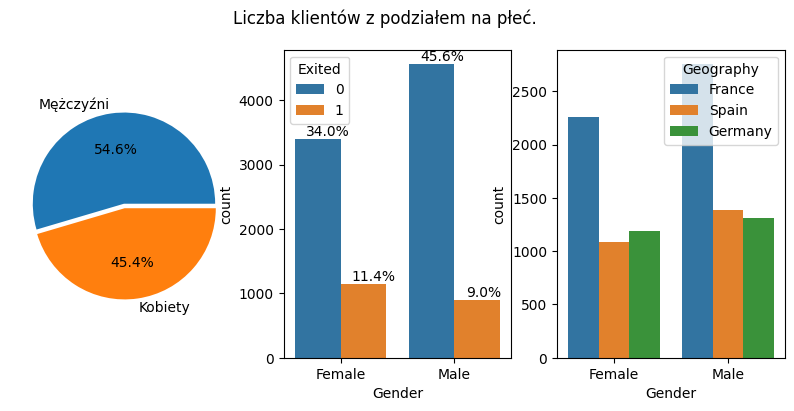

In [256]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,4))
ax[0].pie(df.Gender.value_counts().values, labels=['Mężczyźni','Kobiety'], autopct="%1.1f%%",explode=[0,0.05])

sns.countplot(data=df, x=df.Gender, hue="Exited", ax=ax[1])
for value in ax[1].patches:
    percentage = "{:.1f}%".format(100*value.get_height()/len(df.Gender))
    x = value.get_x() + value.get_width() / 2 - 0.1
    y = value.get_y() + value.get_height() + 50
    ax[1].annotate(percentage, (x,y), size=10)
    
ax[2] = sns.countplot(data=df, x=df.Gender, hue="Geography", ax=ax[2])
plt.suptitle('Liczba klientów z podziałem na płeć.')
plt.show()

In [232]:
coef, p = spearmanr(df.Exited, df.Gender)
print('Statistic=%.3f, p=%.3f' % (coef, p))

Statistic=-0.107, p=0.000


Liczba mężczyzn jest większa od liczby kobiet o ponad 9%.  
W każdym kraju liczba mężczyzn przewyższa liczbę kobiet.  
Kobiety częściej dezaktywują swoje usługi bankowe niż mężczyźni.

### <a id = "R2.5">2.5. Variable Age</a>

In [29]:
print(f'Min. age: {df.Age.min()}, max age: {df.Age.max()}, unikalnych wartości: {df.Age.nunique()}')

Min. age: 18, max age: 92, unikalnych wartości: 70


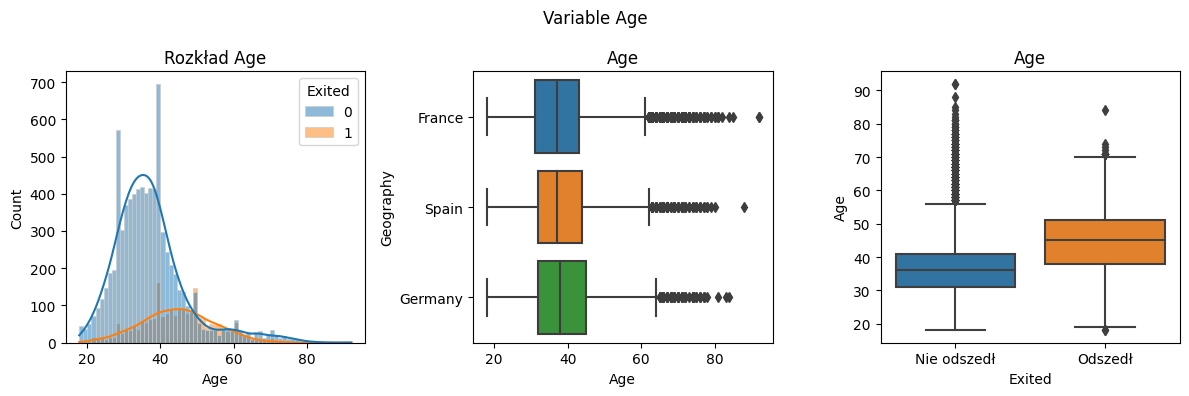

In [333]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

sns.histplot(
    df,
    x="Age", 
    hue="Exited",
    multiple="layer",
    edgecolor=".8",
    linewidth=.5,
    kde=True,
    ax=ax[0]
)
ax[0].set_title('Rozkład Age')

sns.boxplot(df, x="Age", y="Geography", ax=ax[1])
ax[1].set_title('Age')
sns.boxplot(df, x="Exited", y="Age", ax=ax[2])
ax[2].set_title('Age')
ax[2].set_xticklabels(['Nie odszedł','Odszedł'])
plt.suptitle('Variable Age')
fig.tight_layout()
plt.show()

In [31]:
check_normal_distr(df, 'Age', 'Exited')

Age
Skośność: 1.0113202630234552, kurtoza: 1.3953470615086956
Statistic=1607.479, p=0.000, dof=69.000
p_normal=0.000 - Zmienna Age NIE posiada rozkładu normalnego


In [331]:
check_normal_distr(df[df.Exited==1], 'Age', 'Exited')

Age
Skośność: 0.07575081617627401, kurtoza: -0.1227758400106369
Statistic=0.000, p=1.000, dof=0.000
p_normal=0.194 - Zmienna Age posiada rozkład normalny


Wiek klientów w poszczególnych krajach posiada podobny podobny rozkład.  
Rozkład zmiennej Age wśród osób które odeszły wykazuje cechy rozkładu normalnego.  
Całość danych Age nie posiada rozkładu Gaussa i należy dokonać transformacji tej zmiennej dla potrzeb budowanych modeli.

### <a id = "R2.6">2.6. Variable Tenure</a>

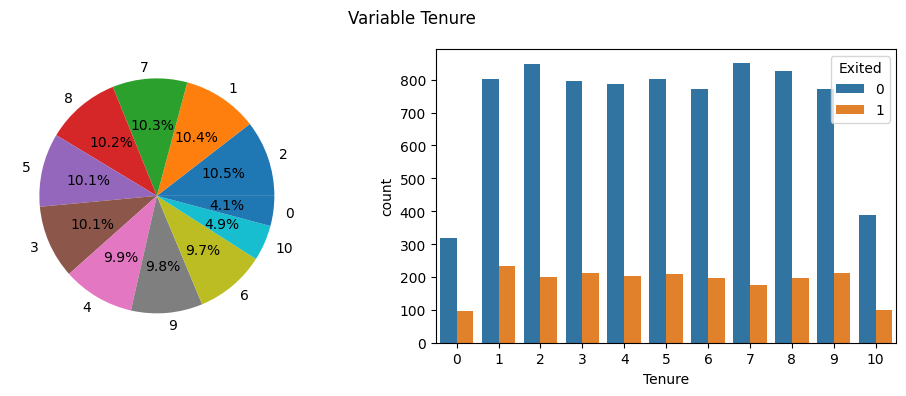

In [329]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
ax[0].pie(df.Tenure.value_counts().values, labels=df.Tenure.value_counts().index, autopct="%1.1f%%")
ax[1] = sns.countplot(x='Tenure', data=df, hue="Exited")
plt.suptitle('Variable Tenure')
fig.tight_layout()
plt.show()

In [36]:
coef, p = spearmanr(df.Exited, df.Tenure)
print('Statistic=%.3f, p=%.3f' % (coef, p))

Statistic=-0.014, p=0.162


Rozkład rezygnacji w zmiennej Tenure jest podobny dla wszystkich wartości.

### <a id = "R2.7">2.7. Variable Balance</a>

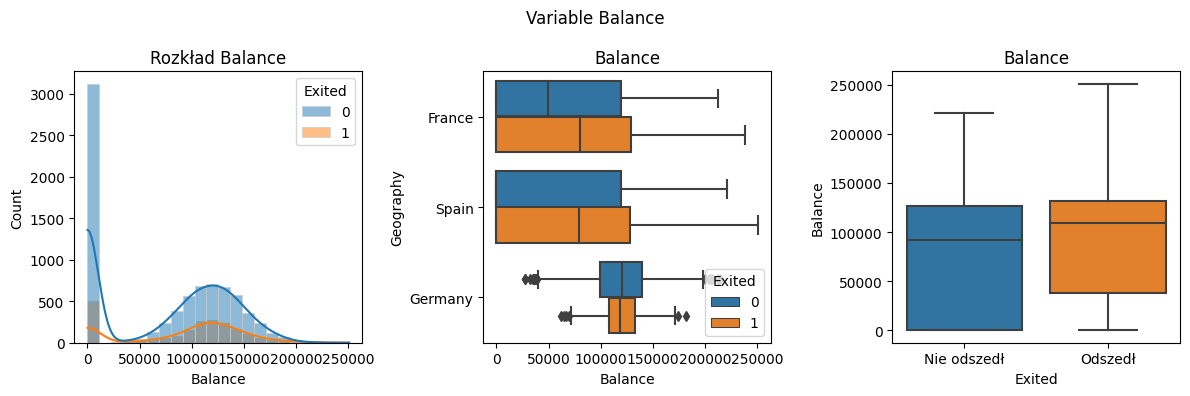

In [340]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

sns.histplot(
    df,
    x="Balance", 
    hue="Exited",
    multiple="layer",
    edgecolor=".8",
    linewidth=.5,
    kde=True,
    ax=ax[0]
)
ax[0].set_title('Rozkład Balance')

sns.boxplot(df, x="Balance", y="Geography", ax=ax[1], hue='Exited')
ax[1].set_title('Balance')
sns.boxplot(df, x="Exited", y="Balance", ax=ax[2])
ax[2].set_title('Balance')
ax[2].set_xticklabels(['Nie odszedł','Odszedł'])
plt.suptitle('Variable Balance')
fig.tight_layout()
plt.show()

In [38]:
df[df.Balance==0].shape[0]

3617

In [337]:
df[df.Balance==0]['Exited'].value_counts()

0    3117
1     500
Name: Exited, dtype: int64

In [39]:
check_normal_distr(df, 'Balance', 'Exited')

Balance
Skośność: -0.14110871094154384, kurtoza: -1.489411767941925
Statistic=7340.535, p=0.000, dof=6381.000
p_normal=0.000 - Zmienna Balance NIE posiada rozkładu normalnego


Ponad 3600 rekordów zawiera prawdopodobnie błędną informację o zerowym saldzie konta (tylko dane z Francji i Hiszpanii).  
Według otrzymanych danych 25% wszystkich klientów, którzy opuścili bank posiadało zerowy stan konta.  
Dane pochodzące z Niemiec posiadają rozkład zbliżony do Gaussa, co pozwala założyć, że w pozostałych krajach powinno być podobnie.  
Zmienna ta stanowi dla nas pewnego rodzaju problem, który może być istotny przy budowie modelu, dlatego możemy:
- pozostawić dane niezmienione,
- nie brać jej pod uwagę,
- spróbować uzupełnić ją proporcjonalnie w miejscach, gdzie wynosi ona 0,
- pozostawić 0 a dane powyżej 0 potraktować jako 1 (stworzyć daną kategoryczną).

### <a id = "R2.8">2.8. Variable NumOfProducts</a>

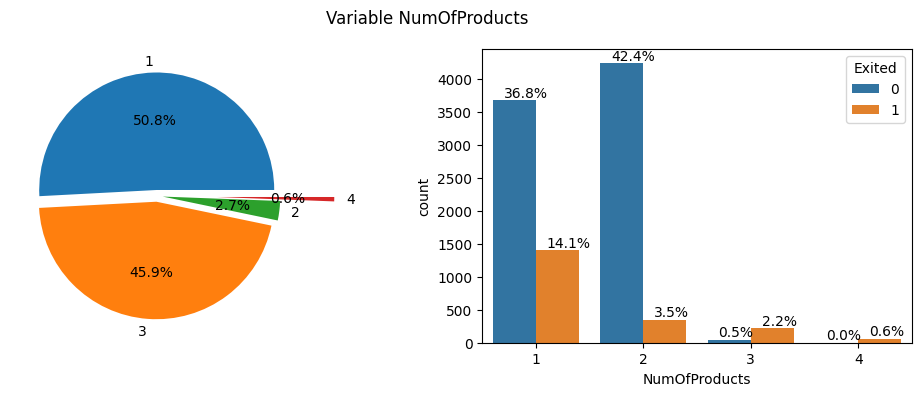

In [276]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
ax[0].pie(df.NumOfProducts.value_counts().values, labels=df.NumOfProducts.unique(),autopct="%1.1f%%", explode=[0.05,0.05,0.05,0.51])


ax[1] = sns.countplot(x='NumOfProducts', data=df, hue="Exited")
for value in ax[1].patches:
        percentage = "{:.1f}%".format(100*value.get_height()/len(df['NumOfProducts']))
        x = value.get_x() + value.get_width() / 2 - 0.1
        y = value.get_y() + value.get_height() + 50
        ax[1].annotate(percentage, (x,y),size=10)
        
plt.suptitle('Variable NumOfProducts')
fig.tight_layout()
plt.show()

In [43]:
coef, p = spearmanr(df.Exited, df.NumOfProducts)
print('Statistic=%.3f, p=%.3f' % (coef, p))

Statistic=-0.125, p=0.000


Większość klientów (96,7%) posiada łącznie 1 lub 2 produkty bankowe.  
Największa liczba odchodzących klientów posiada tylko jedną usługę.  
Można pogrupować klientów posiadających 2 i więcej produkty, aby zmniejszyć nierównowagę klas.

### <a id = "R2.9">2.9. Variable EstimatedSalary</a>

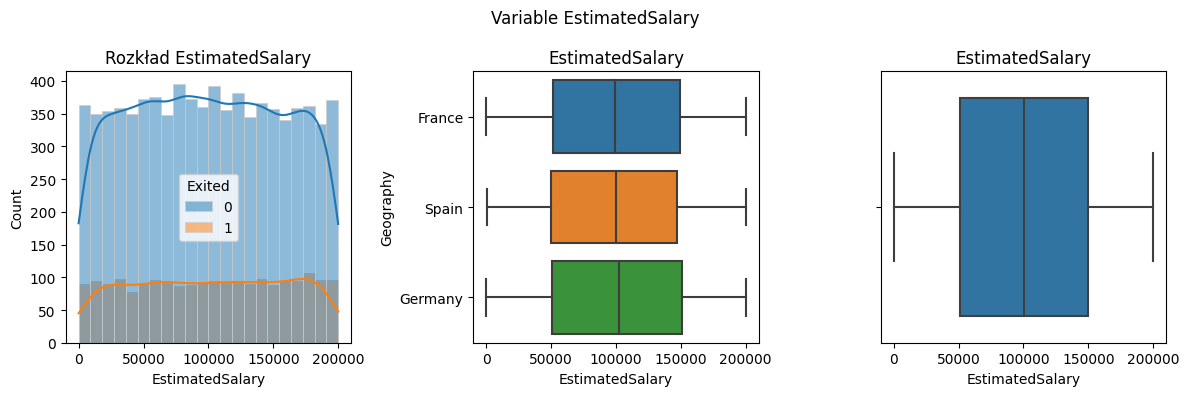

In [259]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

sns.histplot(
    df,
    x="EstimatedSalary", 
    hue="Exited",
    multiple="layer",
    edgecolor=".8",
    linewidth=.5,
    kde=True,
    ax=ax[0]
)
ax[0].set_title('Rozkład EstimatedSalary')

sns.boxplot(df, x="EstimatedSalary", y="Geography", ax=ax[1])
ax[1].set_title('EstimatedSalary')
sns.boxplot(df, x="EstimatedSalary", ax=ax[2])
ax[2].set_title('EstimatedSalary')
plt.suptitle('Variable EstimatedSalary')
fig.tight_layout()
plt.show()

In [45]:
check_normal_distr(df, 'EstimatedSalary', 'Exited')

EstimatedSalary
Skośność: 0.0020853576615585162, kurtoza: -1.1815184473915485
Statistic=10000.000, p=0.492, dof=9998.000
p_normal=0.000 - Zmienna EstimatedSalary NIE posiada rozkładu normalnego


Zmienna
Zmienna EstimatedSalary nie zawiera wartości odstających. 

### <a id = "R2.10">2.10. Variable HasCrCard</a>

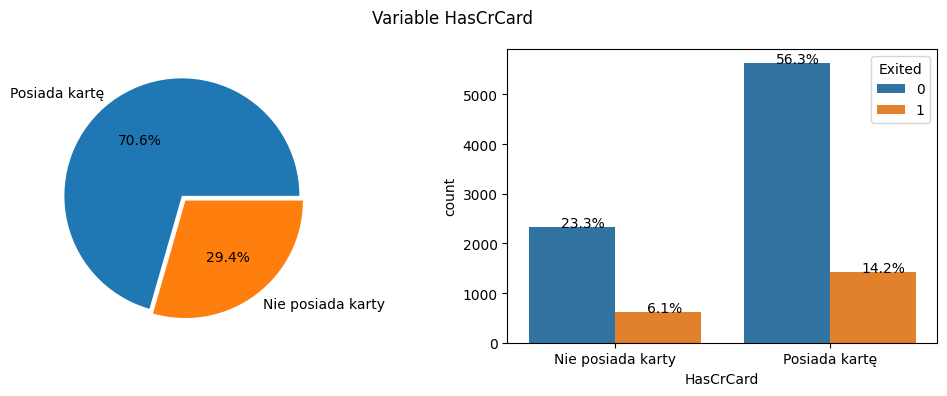

In [297]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
ax[0].pie(df.HasCrCard.value_counts().values, labels=['Posiada kartę','Nie posiada karty'], autopct="%1.1f%%",explode=[0,0.05])


ax[1] = sns.countplot(x='HasCrCard', data=df, hue="Exited")
for value in ax[1].patches:
        percentage = "{:.1f}%".format(100*value.get_height()/len(df['NumOfProducts']))
        x = value.get_x() + value.get_width() / 2 - 0.05
        y = value.get_y() + value.get_height()
        ax[1].annotate(percentage, (x,y),size=10)
ax[1].set_xticklabels(['Nie posiada karty','Posiada kartę'])
plt.suptitle('Variable HasCrCard')
fig.tight_layout()
plt.show()

In [48]:
coef, p = spearmanr(df.Exited, df.HasCrCard)
print('Statistic=%.3f, p=%.3f' % (coef, p))

Statistic=-0.007, p=0.475


Ponad 70% klientów posiada karty kredytowe.  
Proporcje klientów którzy odeszli i posiadali kartę kredytową są podobne jak klientów, którzy karty nie posiadali.

### <a id = "R2.11">2.11. Variable IsActiveMember</a>

In [292]:
df.IsActiveMember.value_counts()

1    5151
0    4849
Name: IsActiveMember, dtype: int64

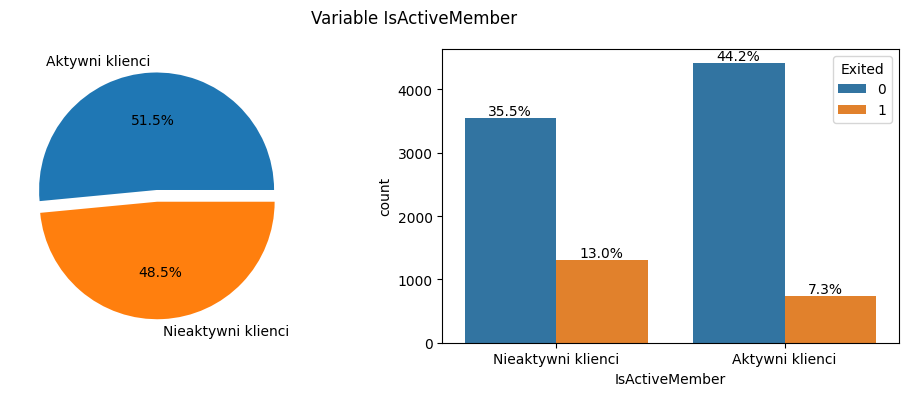

In [296]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
ax[0].pie(df.IsActiveMember.value_counts().values, labels=['Aktywni klienci','Nieaktywni klienci'],autopct="%1.1f%%", explode=[0.05,0.05])


ax[1] = sns.countplot(x='IsActiveMember', data=df, hue="Exited")
for value in ax[1].patches:
        percentage = "{:.1f}%".format(100*value.get_height()/len(df['IsActiveMember']))
        x = value.get_x() + value.get_width() / 2 - 0.1
        y = value.get_y() + value.get_height() + 50
        ax[1].annotate(percentage, (x,y),size=10)
ax[1].set_xticklabels(['Nieaktywni klienci','Aktywni klienci'])
plt.suptitle('Variable IsActiveMember')
fig.tight_layout()
plt.show()

In [51]:
coef, p = spearmanr(df.Exited, df.IsActiveMember)
print('Statistic=%.3f, p=%.3f' % (coef, p))

Statistic=-0.156, p=0.000


Liczba klientów którzy korzystają i nie korzystają aktywnie z usług rozkłada się niemalże po połowie.  
Prawie dwukrotnie więcej nieaktywnych klientów zrezygnowało z usług bankowych.

## <a id = "R3">3. Przygotowanie danych</a>

In [364]:
# import bibliotek wspomagających transformację danych do rozkładów zbliżonych do rozkładu Gaussa
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
pt = PowerTransformer(method='box-cox', standardize=True)
qt = QuantileTransformer(output_distribution='normal')

### <a id = "R3.1">3.1. Transformujemy zmienną Age do rozkładu zbliżonego do normalnego</a>

In [365]:
data_pt_all = pt.fit_transform(df.Age.values.reshape(-1,1))
data_pt = pt.fit_transform(drop_outliers(df,'Age').reshape(-1,1))

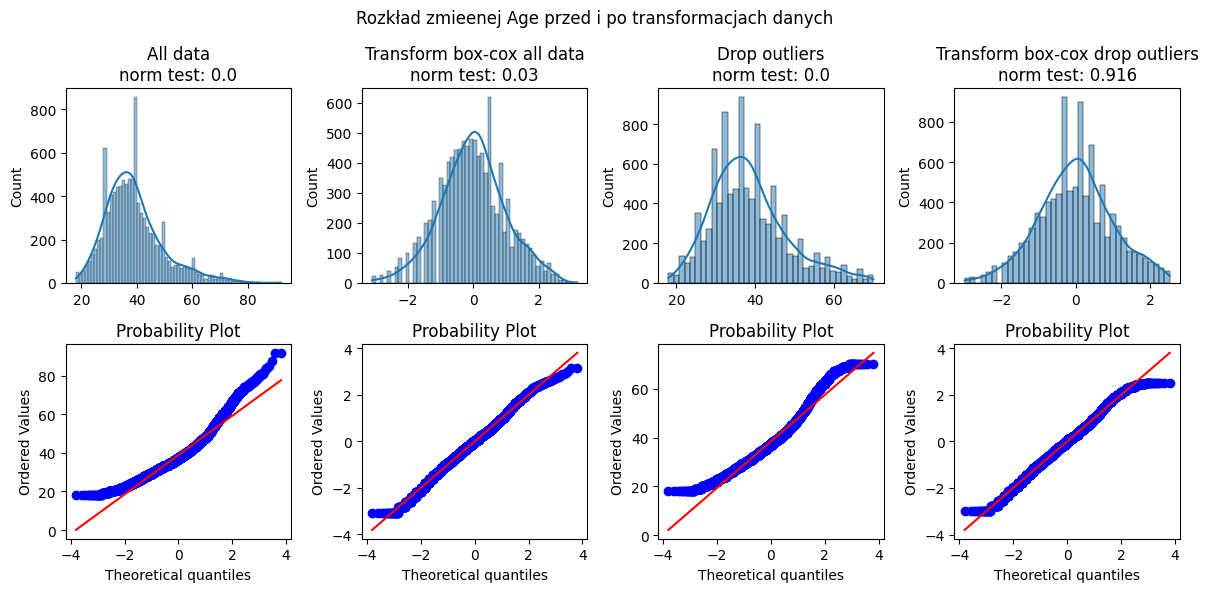

In [366]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12,6))

sns.histplot(df.Age.values, kde=True, ax=ax[0,0], legend=False)
ax[0,0].set_title(f'All data\nnorm test: {round(normaltest(df.Age)[1],3)}')


sns.histplot(data_pt_all, kde=True, ax=ax[0,1], legend=False)
ax[0,1].set_title(f'Transform box-cox all data\nnorm test: {round(normaltest(data_pt_all.reshape(-1))[1],3)}')

sns.histplot(drop_outliers(df,'Age'), kde=True, bins=38, ax=ax[0,2], legend=False)
ax[0,2].set_title(f'Drop outliers\nnorm test: {round(normaltest(drop_outliers(df,"Age"))[1],3)}')

sns.histplot(data_pt, kde=True, bins=38, ax=ax[0,3], legend=False)
ax[0,3].set_title(f'Transform box-cox drop outliers\nnorm test: {round(normaltest(data_pt.reshape(-1))[1],3)}')

probplot(df.Age.values.reshape(1,-1)[0],plot=ax[1,0])
probplot(data_pt_all.reshape(1,-1)[0],plot=ax[1,1])
probplot(drop_outliers(df,'Age').reshape(1,-1)[0],plot=ax[1,2])
probplot(data_pt.reshape(1,-1)[0],plot=ax[1,3])
plt.suptitle('Rozkład zmieenej Age przed i po transformacjach danych')
plt.tight_layout()
plt.show()

Rozkład zmiennej Age najbardziej zbliżony do rozkładu normalnego uzyskamy po transformacji po usunięciu wartości odstających.

In [55]:
df = df.drop(drop_outliers(df,'Age'), axis=0).reset_index(drop=True)

### <a id = "R3.2">3.2. Transformujemy zmienną CreditScore do rozkładu zbliżonego do normalnego</a>

In [367]:
data_pt_all = pt.fit_transform(df.CreditScore.values.reshape(-1,1))
data_qt_all = qt.fit_transform(df.CreditScore.values.reshape(-1,1))
data_pt = pt.fit_transform(drop_outliers(df,'CreditScore').reshape(-1,1))
data_qt = qt.fit_transform(drop_outliers(df,'CreditScore').reshape(-1,1))

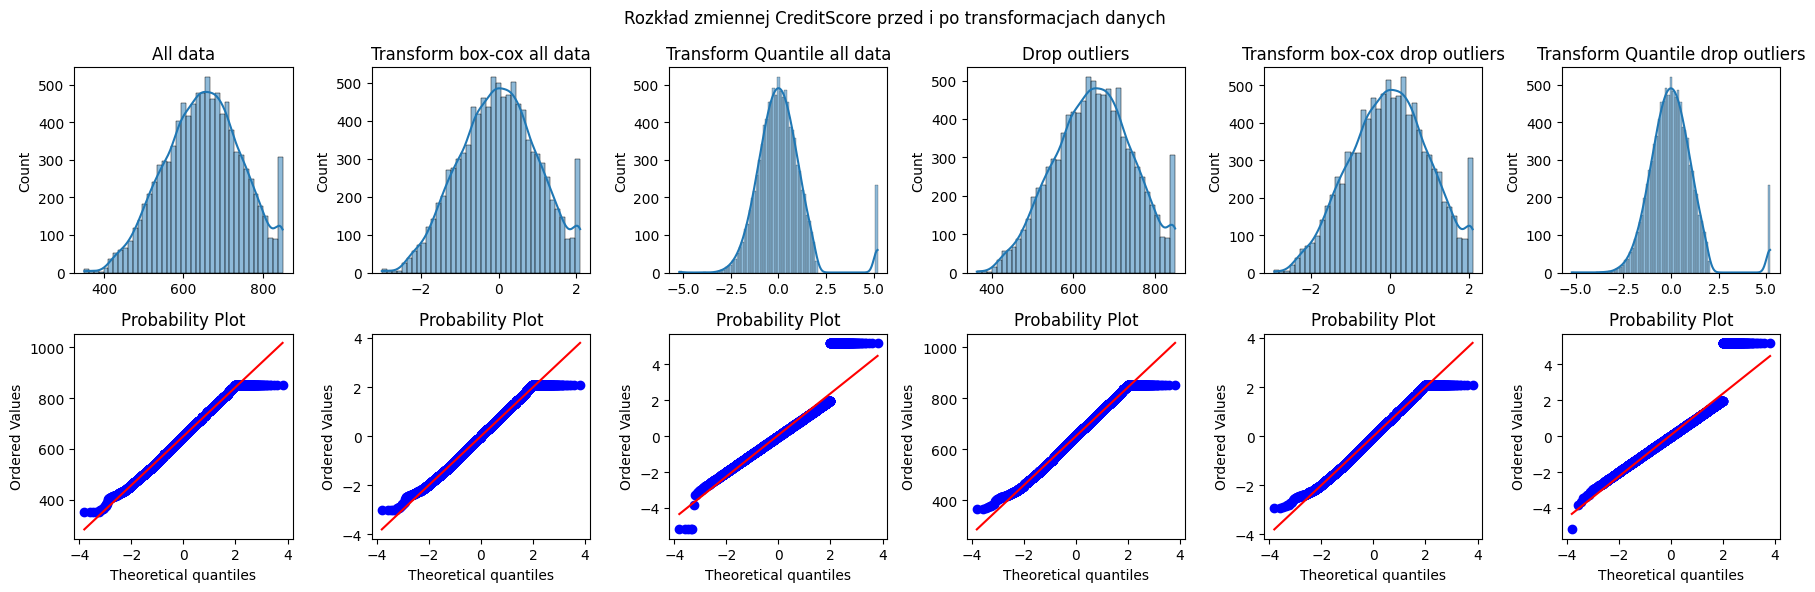

In [368]:
fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(18,6))

sns.histplot(df.CreditScore.values, kde=True, ax=ax[0,0], legend=False)
ax[0,0].set_title('All data')

sns.histplot(data_pt_all, kde=True, ax=ax[0,1], legend=False)
ax[0,1].set_title('Transform box-cox all data')

sns.histplot(data_qt_all, kde=True, ax=ax[0,2], legend=False)
ax[0,2].set_title('Transform Quantile all data')

sns.histplot(drop_outliers(df,'CreditScore'), kde=True, ax=ax[0,3], legend=False)
ax[0,3].set_title('Drop outliers')

sns.histplot(data_pt, kde=True, ax=ax[0,4], legend=False)
ax[0,4].set_title('Transform box-cox drop outliers')

sns.histplot(data_qt, kde=True, ax=ax[0,5], legend=False)
ax[0,5].set_title('Transform Quantile drop outliers')

probplot(df.CreditScore.values.reshape(1,-1)[0],plot=ax[1,0])
probplot(data_pt_all.reshape(1,-1)[0],plot=ax[1,1])
probplot(data_qt_all.reshape(1,-1)[0],plot=ax[1,2])
probplot(drop_outliers(df,'CreditScore').reshape(1,-1)[0],plot=ax[1,3])
probplot(data_pt.reshape(1,-1)[0],plot=ax[1,4])
probplot(data_qt.reshape(1,-1)[0],plot=ax[1,5])
plt.suptitle('Rozkład zmiennej CreditScore przed i po transformacjach danych')
plt.tight_layout()
plt.show()

In [369]:
normaltest(data_qt)

NormaltestResult(statistic=array([3134.24885594]), pvalue=array([0.]))

Rozkład zmiennej CreditScore po transformacjach i usunięciu wartości odstających nie poprawia jakości danych.

### <a id = "R3.3">3.3. Transformujemy zmienną EstimatedSalary do rozkładu zbliżonego do normalnego</a>

In [372]:
data_qt_all = qt.fit_transform(df.EstimatedSalary.values.reshape(-1,1))

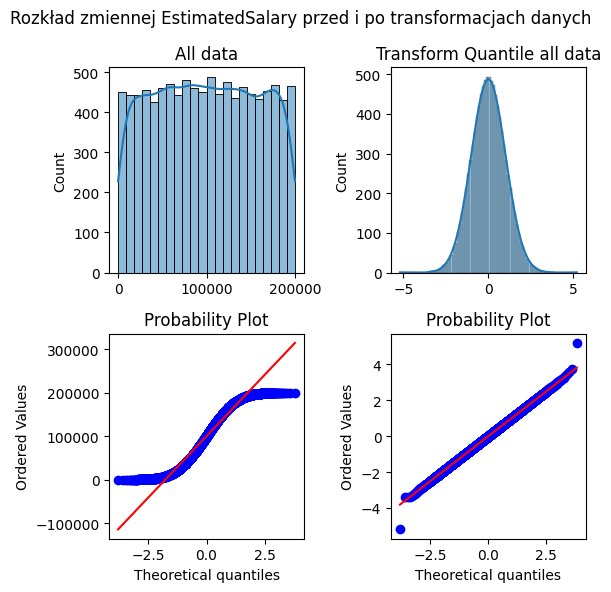

In [373]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6,6))

sns.histplot(df.EstimatedSalary.values, kde=True, ax=ax[0,0], legend=False)
ax[0,0].set_title('All data')

sns.histplot(data_qt_all, kde=True, ax=ax[0,1], legend=False)
ax[0,1].set_title('Transform Quantile all data')

probplot(df.EstimatedSalary.values.reshape(1,-1)[0],plot=ax[1,0])
probplot(data_qt_all.reshape(1,-1)[0],plot=ax[1,1])

plt.suptitle('Rozkład zmiennej EstimatedSalary przed i po transformacjach danych')
plt.tight_layout()
plt.show()

In [374]:
normaltest(data_qt_all)[1][0]

0.22998722296999125

Rozkład zmiennej EstimatedSalary najbardziej zbliżony do rozkładu normalnego uzyskamy po transformacji.

### <a id = "R3.4">3.4. Uzupełniamy i transformujemy zmienną Balance do rozkładu zbliżonego do normalnego</a>

In [375]:
df_balance = df[(df.Balance!=0)&(df.Geography!='Germany')]
df_Ger = df[df.Geography=='Germany']

In [376]:
check_normal_distr(df_balance, 'Balance', 'Exited')

Balance
Skośność: 0.04796840932560716, kurtoza: 0.05293243138610526
Statistic=3870.706, p=0.503, dof=3872.000
p_normal=0.373 - Zmienna Balance posiada rozkład normalny


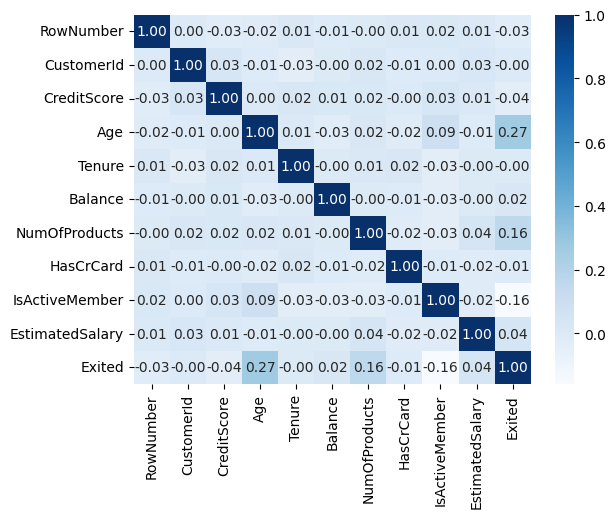

In [377]:
_ = sns.heatmap(df_balance.corr(numeric_only=True), annot=True, cmap='Blues', fmt='.2f')

Zmienna Balance nie jest skorelowana z żadną zmienną, więc zera zastąpimy rozkładem normalnym z istniejących danych. 
Można zauważyć, że w tej konfiguracji danych pojawiła się słaba korelacja zmiennych Exited i Age.

In [378]:
df_balance.Balance.describe()

count      3874.000000
mean     119890.560532
std       31931.148230
min        3768.690000
25%       98367.312500
50%      120032.470000
75%      140987.192500
max      250898.090000
Name: Balance, dtype: float64

In [392]:
df_fill = df.copy()

In [398]:
# tworzymy wersję kategoryczną zmiennej Balance
df_fill['Balance_category'] = [ 0 if x==0 else 1 for x in df_fill.Balance  ]

In [399]:
# tworzymy uzupełnienie zer wartościami z obliczonymi z rozkładu normalnego
normal_Balance = pd.DataFrame(np.random.normal(df_balance.Balance.describe()['mean'],df_balance.Balance.describe()['std'],df[df.Balance==0].shape[0]), columns=['values'])

In [400]:
normal_Balance[normal_Balance['values']<0]

,values


In [401]:
normal_Balance.set_index(df_fill[df_fill.Balance == 0].index, inplace=True)

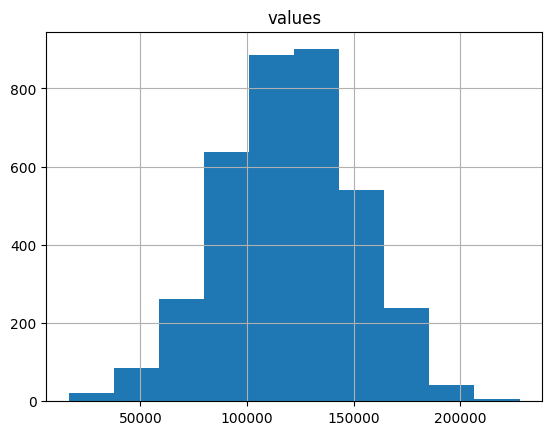

In [402]:
_ = normal_Balance.hist()

In [403]:
df_fill.loc[df_fill.Balance == 0, 'Balance'] = normal_Balance['values']

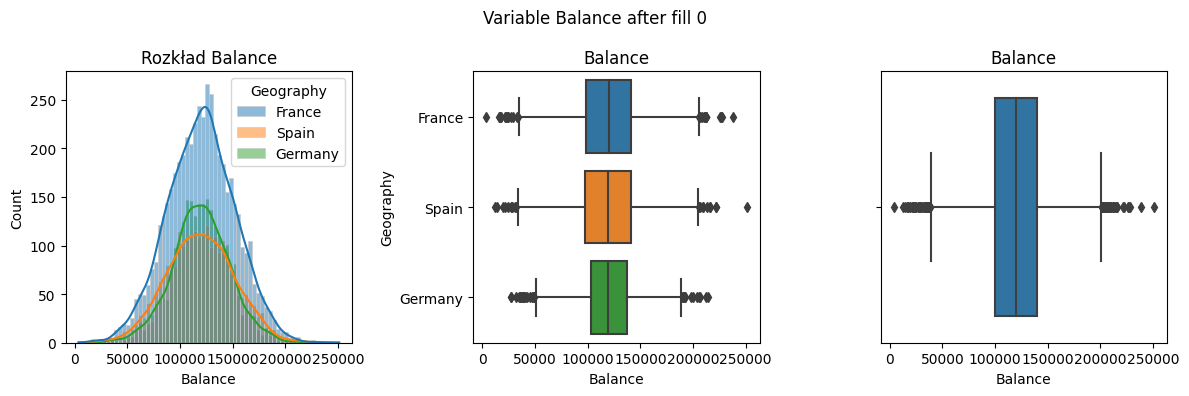

In [404]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

sns.histplot(
    df_fill,
    x="Balance", 
    hue="Geography",
    multiple="layer",
    edgecolor=".8",
    linewidth=.5,
    kde=True,
    ax=ax[0]
)
ax[0].set_title('Rozkład Balance')

sns.boxplot(df_fill, x="Balance", y="Geography", ax=ax[1])
ax[1].set_title('Balance')
sns.boxplot(df_fill, x="Balance", ax=ax[2])
ax[2].set_title('Balance')
plt.suptitle('Variable Balance after fill 0')
fig.tight_layout()
plt.show()

In [405]:
data_pt_all = pt.fit_transform(df_fill.Balance.values.reshape(-1,1))
data_qt_all = qt.fit_transform(df_fill.Balance.values.reshape(-1,1))
data_pt = pt.fit_transform(drop_outliers(df_fill,'Balance').reshape(-1,1))
data_qt = qt.fit_transform(drop_outliers(df_fill,'Balance').reshape(-1,1))

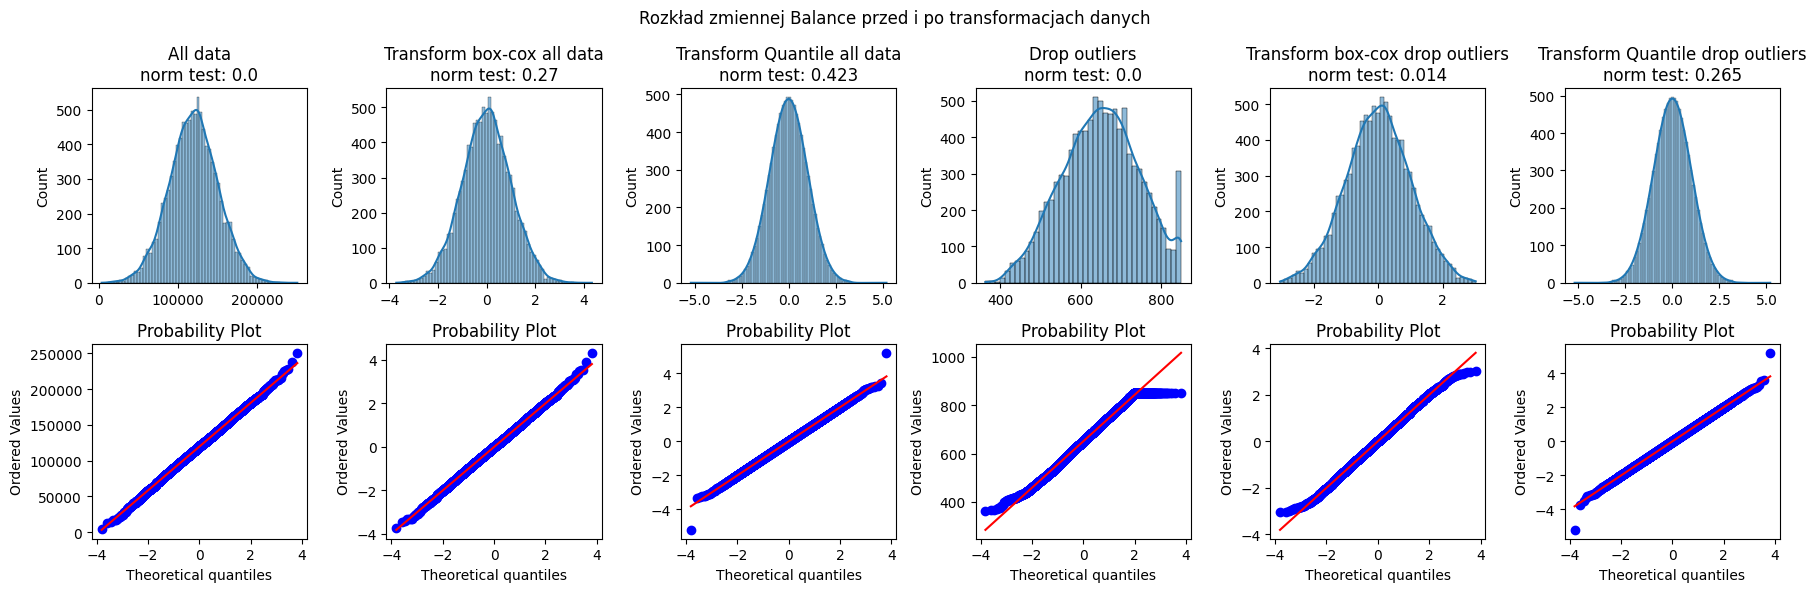

In [406]:
fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(18,6))

sns.histplot(df_fill.Balance.values, kde=True, ax=ax[0,0], legend=False)
ax[0,0].set_title(f'All data\nnorm test: {round(normaltest(df.Balance)[1],3)}')

sns.histplot(data_pt_all, kde=True, ax=ax[0,1], legend=False)
ax[0,1].set_title(f'Transform box-cox all data\nnorm test: {round(normaltest(data_pt_all.reshape(-1))[1],3)}')

sns.histplot(data_qt_all, kde=True, ax=ax[0,2], legend=False)
ax[0,2].set_title(f'Transform Quantile all data\nnorm test: {round(normaltest(data_qt_all.reshape(-1))[1],3)}')

sns.histplot(drop_outliers(df,'CreditScore'), kde=True, ax=ax[0,3], legend=False)
ax[0,3].set_title(f'Drop outliers\nnorm test: {round(normaltest(drop_outliers(df,"CreditScore"))[1],3)}')

sns.histplot(data_pt, kde=True, ax=ax[0,4], legend=False)
ax[0,4].set_title(f'Transform box-cox drop outliers\nnorm test: {round(normaltest(data_pt.reshape(-1))[1],3)}')

sns.histplot(data_qt, kde=True, ax=ax[0,5], legend=False)
ax[0,5].set_title(f'Transform Quantile drop outliers\nnorm test: {round(normaltest(data_qt.reshape(-1))[1],3)}')

probplot(df_fill.Balance.values.reshape(1,-1)[0],plot=ax[1,0])
probplot(data_pt_all.reshape(1,-1)[0],plot=ax[1,1])
probplot(data_qt_all.reshape(1,-1)[0],plot=ax[1,2])
probplot(drop_outliers(df,'CreditScore').reshape(1,-1)[0],plot=ax[1,3])
probplot(data_pt.reshape(1,-1)[0],plot=ax[1,4])
probplot(data_qt.reshape(1,-1)[0],plot=ax[1,5])
plt.suptitle('Rozkład zmiennej Balance przed i po transformacjach danych')
plt.tight_layout()
plt.show()

Najlepszym wyborem do dalszej pracy wydaje się transformacja Quantile zmiennej Balance na wszystkich danych.

In [407]:
df_fill

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Balance_category
0,1,15634602,Hargrave,619,France,Female,42,2,155628.303596,1,1,1,101348.88,1,0
1,2,15647311,Hill,608,Spain,Female,41,1,83807.860000,1,0,1,112542.58,0,1
2,3,15619304,Onio,502,France,Female,42,8,159660.800000,3,1,0,113931.57,1,1
3,4,15701354,Boni,699,France,Female,39,1,117130.959897,2,0,0,93826.63,0,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.820000,1,1,1,79084.10,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,84728.398541,2,1,0,96270.64,0,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.610000,1,1,1,101699.77,0,1
9997,9998,15584532,Liu,709,France,Female,36,7,146269.205764,1,0,1,42085.58,1,0
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.310000,2,1,0,92888.52,1,1


## <a id = "R3.5">3.5. Przygotowanie danych dla modeli</a>

In [711]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
std_scaler = StandardScaler()

In [609]:
df_transformed = pd.DataFrame()
df_scaled = pd.DataFrame()

In [610]:
df_scaled['CreditScore'] = pd.DataFrame(std_scaler.fit_transform(df_fill.Balance.values.reshape(-1,1)))

In [611]:
df_transformed['Balance_fill_transformed'] = pd.DataFrame(qt.fit_transform(df_fill.Balance.values.reshape(-1,1)))
df_transformed['Age'] = pd.DataFrame(pt.fit_transform(df.Age.values.reshape(-1,1)))
df_transformed['EstimatedSalary'] = pd.DataFrame(qt.fit_transform(df.EstimatedSalary.values.reshape(-1,1)))

In [612]:
df_transformed['NoP'] = [ 0 if x==1 else 1 for x in df.NumOfProducts ]

In [613]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False).set_output(transform='pandas')
df_encoded = encoder.fit_transform(df_fill[['Geography','Gender','NumOfProducts','Tenure']])

In [614]:
data = pd.concat([df_transformed, df_scaled, df_encoded, df.HasCrCard, df.Exited], axis=1)

In [615]:
data.columns

Index(['Balance_fill_transformed', 'Age', 'EstimatedSalary', 'NoP',
       'CreditScore', 'Geography_Germany', 'Geography_Spain', 'Gender_Male',
       'NumOfProducts_2', 'NumOfProducts_3', 'NumOfProducts_4', 'Tenure_1',
       'Tenure_2', 'Tenure_3', 'Tenure_4', 'Tenure_5', 'Tenure_6', 'Tenure_7',
       'Tenure_8', 'Tenure_9', 'Tenure_10', 'HasCrCard', 'Exited'],
      dtype='object')

## Sprawdzimy możliwości zbudowania modelu przewidującego rezygnację klienta
## <a id = "R4">Modele matematyczne</a>  

Zbudujemy proste modele, za pomocą których sprawdzimy jak przewidują odejście klienta na takich samych danych.

In [589]:
from sklearn.metrics import accuracy_score, confusion_matrix
# function show confusion matrix
def show_cm(test, pred, title=''):
    fig, ax = plt.subplots(ncols=1, figsize=(4, 4))
    cm = confusion_matrix(test, pred)
    names = ['True Neg.', 'False Pos.', 'False Neg.', 'True Pos.']
    counts = [x for x in cm.flatten()]
    percentages = ['{0:.2%}'.format(x) for x in cm.flatten() / np.sum(cm)]
    labels = [f'{x1}\n{x2}\n{x3}' for x1, x2, x3 in zip(names, counts, percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cm/np.sum(cm), annot=labels, fmt='', cmap='Blues', ax=ax, cbar=None)
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('True Values');
    ax.xaxis.set_ticklabels(['False', 'True'])
    ax.yaxis.set_ticklabels(['False', 'True'])
    plt.title(f'{title}\nAccuracy: {round(accuracy_score(test, pred), 2)*100}%')
    plt.show()

In [590]:
def conf_matrix(test, pred, title=''):
    cm = confusion_matrix(test, pred)
    names = ['True Neg.', 'False Pos.', 'False Neg.', 'True Pos.']
    counts = [x for x in cm.flatten()]
    percentages = ['{0:.2%}'.format(x) for x in cm.flatten() / np.sum(cm)]
    labels = [f'{x1}\n{x2}\n{x3}' for x1, x2, x3 in zip(names, counts, percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    return cm/np.sum(cm), labels, f'{title}\nAccuracy: {round(accuracy_score(test, pred), 2)*100}%'

#### Biblioteka sklearn

In [439]:
from sklearn.linear_model import LogisticRegression

In [440]:
def logistic_regression_model(xtrain, ytrain, xtest):
    model = LogisticRegression(solver='liblinear')
    model.fit(xtrain, ytrain)
    y_pred = model.predict(xtest)
    return y_pred

#### Biblioteka tensorflow

In [441]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [442]:
def sequential_model(xtrain, ytrain, xtest):
    es = EarlyStopping(monitor='binary_accuracy', patience=20)
    number_of_classes = 1
    number_of_features = xtrain.shape[1]
    model = Sequential()
    model.add(Dense(128, activation = 'relu', input_dim = number_of_features))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss=["binary_crossentropy"],
        optimizer= 'adam',
        metrics=['binary_accuracy'])

    history = model.fit(xtrain, ytrain.reshape(-1,1), validation_split=.2, epochs=200, verbose=0, shuffle=True, batch_size=16, callbacks=es)

    y_pred = model.predict(xtest, verbose=0)
    y_pred = (y_pred > 0.5).astype("int32")
    return y_pred

#### GradientBoostingClassifier

In [443]:
from sklearn.ensemble import GradientBoostingClassifier

In [444]:
def gradient_boost_model(xtrain, ytrain, xtest):
    clf = GradientBoostingClassifier(n_estimators=100, 
                                     learning_rate=.01, 
                                     max_depth=5, 
                                     random_state=0).fit(xtrain, ytrain)
    return clf.predict(xtest)

#### XGBOOST

In [445]:
from xgboost import XGBClassifier

In [446]:
def xgboost_model(xtrain, ytrain, xtest):
    model = XGBClassifier()
    model.fit(xtrain, ytrain)
    return model.predict(xtest)

#### Random Forest Classifier

In [447]:
from sklearn.ensemble import RandomForestClassifier

In [448]:
def random_forest_model(xtrain, ytrain, xtest):
    rfc = RandomForestClassifier()
    rfc.fit(xtrain,ytrain)
    return rfc.predict(xtest)

#### DecisionTreeClassifier

In [449]:
from sklearn.tree import DecisionTreeClassifier

In [450]:
def decision_tree_model(xtrain, ytrain, xtest):
    dtc = DecisionTreeClassifier()
    dtc.fit(xtrain,ytrain)
    return dtc.predict(xtest)

## <a id = "R4.1">4.1. Budujemy modele w oparciu o dane z Niemiec</a>

Skoro w Niemczech odnotowano największą liczbę rezygnacji klientów, sprawdzimy jak model zbudowany o te dane będzie przewidywał odejścia klientów we Francji i Hiszpanii.

In [704]:
np_data_germany = data[data.Geography_Germany==1].values

In [705]:
X_germany, y_germany = np_data_germany[:, :-1], np_data_germany[:, -1]

In [706]:
X_train_germany, X_test_germany, y_train_germany, y_test_germany = train_test_split(X_germany, y_germany, test_size=.20, shuffle=True)

In [707]:
mx_logistic, labels_logistic, title_logistic = conf_matrix(y_test_germany, logistic_regression_model(X_train_germany, y_train_germany, X_test_germany), 'Logistic regression')
mx_sequential, labels_sequential, title_sequential = conf_matrix(y_test_germany, sequential_model(X_train_germany, y_train_germany, X_test_germany), 'Sequential model')
mx_gradient, labels_gradient, title_gradient = conf_matrix(y_test_germany, gradient_boost_model(X_train_germany, y_train_germany, X_test_germany), 'Gradient Boosting model')
mx_xgb, labels_xgb, title_xgb = conf_matrix(y_test_germany, xgboost_model(X_train_germany, y_train_germany, X_test_germany), 'XGBoost model')
mx_rfc, labels_rfc, title_rfc = conf_matrix(y_test_germany, random_forest_model(X_train_germany, y_train_germany, X_test_germany), 'Random forest model')
mx_dtc, labels_dtc, title_dtc = conf_matrix(y_test_germany, decision_tree_model(X_train_germany, y_train_germany, X_test_germany), 'Decision tree model')

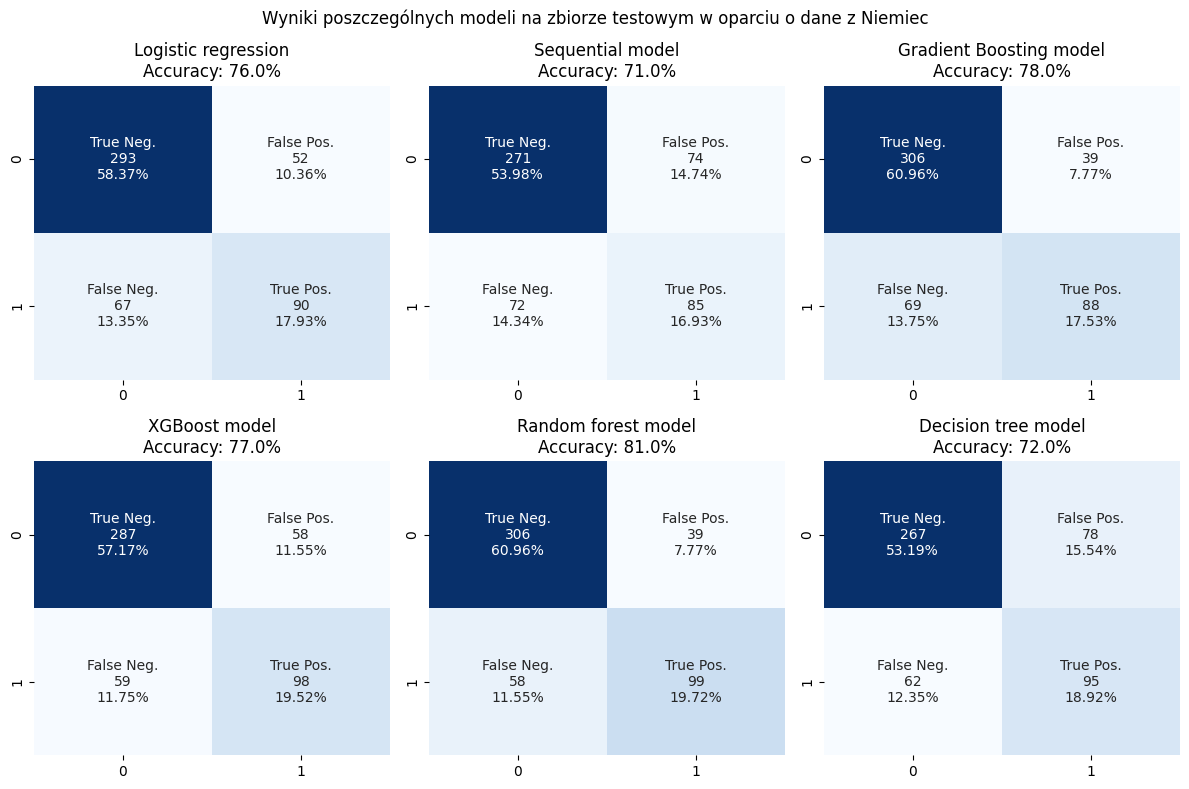

In [708]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
sns.heatmap(mx_logistic, annot=labels_logistic, fmt='', cmap='Blues', cbar=None, ax=ax[0,0])
ax[0,0].title.set_text(title_logistic)
sns.heatmap(mx_sequential, annot=labels_sequential, fmt='', cmap='Blues', cbar=None, ax=ax[0,1])
ax[0,1].title.set_text(title_sequential)
sns.heatmap(mx_gradient, annot=labels_gradient, fmt='', cmap='Blues', cbar=None, ax=ax[0,2])
ax[0,2].title.set_text(title_gradient)
sns.heatmap(mx_xgb, annot=labels_xgb, fmt='', cmap='Blues', cbar=None, ax=ax[1,0])
ax[1,0].title.set_text(title_xgb)
sns.heatmap(mx_rfc, annot=labels_rfc, fmt='', cmap='Blues', cbar=None, ax=ax[1,1])
ax[1,1].title.set_text(title_rfc)
sns.heatmap(mx_dtc, annot=labels_dtc, fmt='', cmap='Blues', cbar=None, ax=ax[1,2])
ax[1,2].title.set_text(title_dtc)
plt.suptitle('Wyniki poszczególnych modeli na zbiorze testowym w oparciu o dane z Niemiec')
fig.tight_layout()
plt.show()

Najlepszy model zbudowany w oparciu o dane pochodzące z Niemiec osiągnął 81% dokładności.  
Sprawdźmy, jak algorytmy dobiorą najlepsze parametry.

In [712]:
rfc = RandomForestClassifier()
param_grid = {"max_depth":[3,4,5,6,7,8,9,10,15],
              "min_samples_split":[3,4,5,6,7,8,9,10,15],
              "min_samples_leaf":[3,4,5,6,7,8,9,10,15],
              "n_estimators": [50,70,90,100],
              "criterion":["gini","entropy"]}
grid_search = GridSearchCV(rfc, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_germany,y_train_germany)
best_param = grid_search.best_params_

In [714]:
rfc = RandomForestClassifier(**best_param)
rfc.fit(X_train_germany,y_train_germany)

RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=9,
                       n_estimators=90)

In [715]:
y_train_pred = rfc.predict(X_train_germany)
y_test_pred  = rfc.predict(X_test_germany)

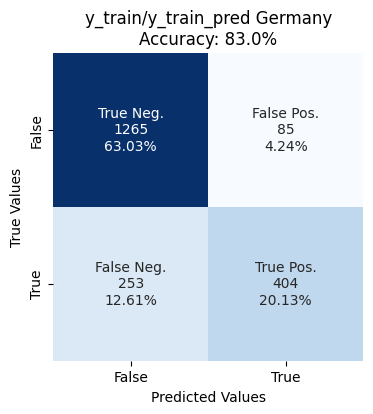

In [729]:
show_cm(y_train_germany, y_train_pred,'y_train/y_train_pred Germany')

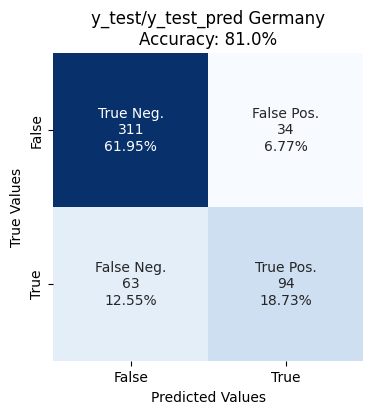

In [730]:
show_cm(y_test_germany, y_test_pred,'y_test/y_test_pred Germany')

Sprawdźmy model na danych Hiszpanii i Francji. 

In [716]:
np_data_FS = data[data.Geography_Germany!=1].values

In [717]:
X_FS, y_FS = np_data_FS[:, :-1], np_data_FS[:, -1]

In [718]:
y_pred_FS = rfc.predict(X_FS)

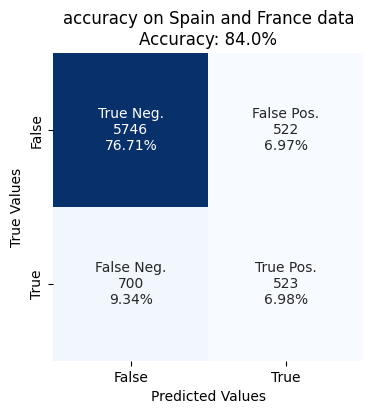

In [731]:
show_cm(y_FS, y_pred_FS,'accuracy on Spain and France data')

## <a id = "R4.2">4.2. Budujemy modele w oparciu o dane ze wszystkich państw</a>

In [732]:
np_data = data.values

In [733]:
X, y = np_data[:, :-1], np_data[:, -1]

In [734]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, shuffle=True)

In [735]:
mx_logistic, labels_logistic, title_logistic = conf_matrix(y_test, logistic_regression_model(X_train, y_train, X_test), 'Logistic regression')
mx_sequential, labels_sequential, title_sequential = conf_matrix(y_test, sequential_model(X_train, y_train, X_test), 'Sequential model')
mx_gradient, labels_gradient, title_gradient = conf_matrix(y_test, gradient_boost_model(X_train, y_train, X_test), 'Gradient Boosting model')
mx_xgb, labels_xgb, title_xgb = conf_matrix(y_test, xgboost_model(X_train, y_train, X_test), 'XGBoost model')
mx_rfc, labels_rfc, title_rfc = conf_matrix(y_test, random_forest_model(X_train, y_train, X_test), 'Random forest model')
mx_dtc, labels_dtc, title_dtc = conf_matrix(y_test, decision_tree_model(X_train, y_train, X_test), 'Decision tree model')

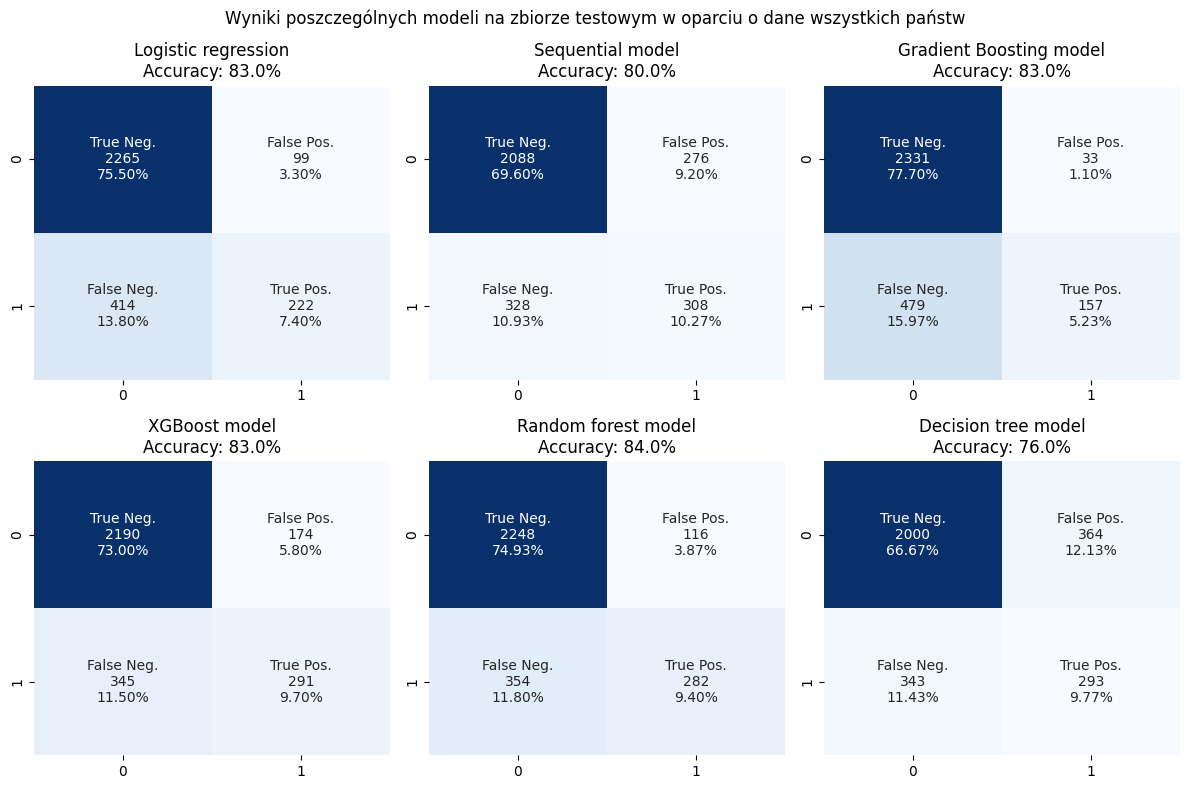

In [736]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
sns.heatmap(mx_logistic, annot=labels_logistic, fmt='', cmap='Blues', cbar=None, ax=ax[0,0])
ax[0,0].title.set_text(title_logistic)
sns.heatmap(mx_sequential, annot=labels_sequential, fmt='', cmap='Blues', cbar=None, ax=ax[0,1])
ax[0,1].title.set_text(title_sequential)
sns.heatmap(mx_gradient, annot=labels_gradient, fmt='', cmap='Blues', cbar=None, ax=ax[0,2])
ax[0,2].title.set_text(title_gradient)
sns.heatmap(mx_xgb, annot=labels_xgb, fmt='', cmap='Blues', cbar=None, ax=ax[1,0])
ax[1,0].title.set_text(title_xgb)
sns.heatmap(mx_rfc, annot=labels_rfc, fmt='', cmap='Blues', cbar=None, ax=ax[1,1])
ax[1,1].title.set_text(title_rfc)
sns.heatmap(mx_dtc, annot=labels_dtc, fmt='', cmap='Blues', cbar=None, ax=ax[1,2])
ax[1,2].title.set_text(title_dtc)
plt.suptitle('Wyniki poszczególnych modeli na zbiorze testowym w oparciu o dane wszystkich państw')
fig.tight_layout()
plt.show()

Najlepszy model zbudowany w oparciu o wszystkie dane 84% dokładności.  
Sprawdźmy, jak algorytmy dobiorą najlepsze parametry.

In [737]:
rfc = RandomForestClassifier()
param_grid = {"max_depth":[3,4,5,6,7,8,9,10,15],
              "min_samples_split":[3,4,5,6,7,8,9,10,15],
              "min_samples_leaf":[3,4,5,6,7,8,9,10,15],
              "n_estimators": [50,70,90,100],
              "criterion":["gini","entropy"]}
grid_search = GridSearchCV(rfc, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train,y_train)
best_param = grid_search.best_params_

In [738]:
rfc = RandomForestClassifier(**best_param)
rfc.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=15, min_samples_leaf=7,
                       min_samples_split=7, n_estimators=90)

In [739]:
y_train_pred = rfc.predict(X_train)
y_test_pred  = rfc.predict(X_test)

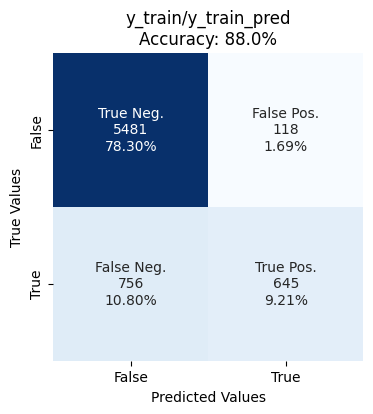

In [740]:
show_cm(y_train, y_train_pred,'y_train/y_train_pred')

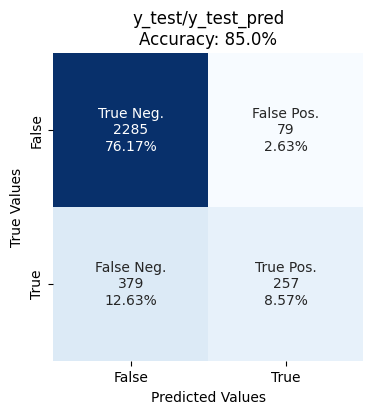

In [741]:
show_cm(y_test, y_test_pred,'y_test/y_test_pred')

## <a id = "R4.3">4.3. Zwiększenie liczebności zmiennej Exited - oversampling SMOTE</a>

In [742]:
from imblearn.over_sampling import SMOTE

In [743]:
smote = SMOTE()

In [744]:
X_smote, y_smote = smote.fit_resample(X_train, y_train)

In [745]:
X_smote.shape

(11198, 22)

In [746]:
X_train.shape

(7000, 22)

In [747]:
y_train.sum()

1401.0

In [748]:
y_smote.sum()

5599.0

In [738]:
rfc.fit(X_smote,y_smote)

RandomForestClassifier(criterion='entropy', max_depth=15, min_samples_leaf=7,
                       min_samples_split=7, n_estimators=90)

In [750]:
y_train_smote = rfc.predict(X_smote)
y_test_pred  = rfc.predict(X_smote)

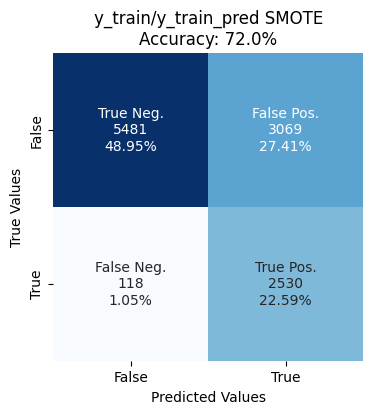

In [754]:
show_cm(y_train_smote, y_smote,'y_train/y_train_pred SMOTE')

In [801]:
y_pred_smote = rfc.predict(X_test)

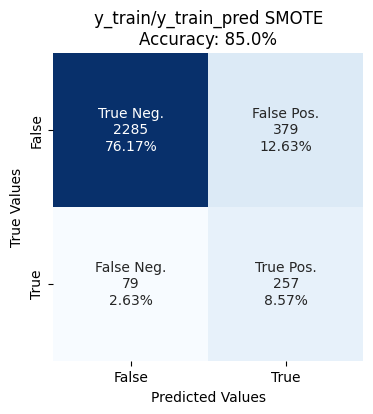

In [802]:
show_cm(y_pred_smote, y_test,'y_train/y_train_pred SMOTE')

## <a id = "R4.4">4.4. Wykorzystanie biblioteki Tensorflow do budowania modelu.</a>

In [771]:
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.constraints import MaxNorm

In [774]:
X_smote.shape

(11198, 22)

### Dobieramy optymalizator

In [780]:
def create_model_optimizer(optimizer='adam'):
    model = Sequential()
    model.add(Dense(256, input_shape=(22,), activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [781]:
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(model__optimizer=optimizer)

model = KerasClassifier(model=create_model_optimizer, epochs=200, batch_size=64, verbose=0)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
grid_result = grid.fit(X_smote, y_smote)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.904004 using {'model__optimizer': 'Nadam'}
0.835687 (0.016380) with: {'model__optimizer': 'SGD'}
0.897397 (0.039262) with: {'model__optimizer': 'RMSprop'}
0.768084 (0.007025) with: {'model__optimizer': 'Adagrad'}
0.751117 (0.006943) with: {'model__optimizer': 'Adadelta'}
0.903645 (0.028076) with: {'model__optimizer': 'Adam'}
0.901683 (0.036043) with: {'model__optimizer': 'Adamax'}
0.904004 (0.033415) with: {'model__optimizer': 'Nadam'}


### Dobieramy kernel

In [779]:
def create_model_init_kernel(init_mode='uniform'):
    model = Sequential()
    model.add(Dense(128, input_shape=(22,), kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(64, kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(1, kernel_initializer=init_mode, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    return model

In [782]:
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(model__init_mode=init_mode)

model = KerasClassifier(model=create_model_init_kernel, epochs=100, batch_size=64, verbose=0)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
grid_result = grid.fit(X_smote, y_smote)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.893198 using {'model__init_mode': 'he_uniform'}
0.866053 (0.045926) with: {'model__init_mode': 'uniform'}
0.891413 (0.031473) with: {'model__init_mode': 'lecun_uniform'}
0.881501 (0.038081) with: {'model__init_mode': 'normal'}
0.499911 (0.000109) with: {'model__init_mode': 'zero'}
0.889895 (0.034427) with: {'model__init_mode': 'glorot_normal'}
0.884091 (0.039074) with: {'model__init_mode': 'glorot_uniform'}
0.893019 (0.029001) with: {'model__init_mode': 'he_normal'}
0.893198 (0.023548) with: {'model__init_mode': 'he_uniform'}


##### Dobieranie funkcji aktywacji

In [784]:
def create_model_activation(activation='relu'):
    model = Sequential()
    model.add(Dense(128, input_shape=(22,), kernel_initializer='he_uniform', activation=activation))
    model.add(Dense(64, kernel_initializer='he_uniform', activation=activation))
    model.add(Dense(1, kernel_initializer='he_uniform', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    return model

In [785]:
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(model__activation=activation)

model = KerasClassifier(model=create_model_activation, epochs=100, batch_size=64, verbose=0)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3) #cv - walidacja krzyżowa, n_jobs - liczba uruchamianych zadań równolegle (-1 - wszystkie rdzenie)
grid_result = grid.fit(X_smote, y_smote)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

C:\Users\Precision7710\python_env\test-ml\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best: 0.884266 using {'model__activation': 'tanh'}
0.803715 (0.008272) with: {'model__activation': 'softmax'}
0.812468 (0.017579) with: {'model__activation': 'softplus'}
0.869530 (0.008467) with: {'model__activation': 'softsign'}
0.881766 (0.019364) with: {'model__activation': 'relu'}
0.884266 (0.011358) with: {'model__activation': 'tanh'}
0.787374 (0.017211) with: {'model__activation': 'sigmoid'}
0.789070 (0.005431) with: {'model__activation': 'hard_sigmoid'}
0.754867 (0.002864) with: {'model__activation': 'linear'}


##### Dobieranie regularyzacji porzucania

In [790]:
def create_model_dropout(dropout_rate, weight_constraint):
    model = Sequential()
    model.add(Dense(128, input_shape=(22,), kernel_initializer='he_uniform', activation='tanh', kernel_constraint=MaxNorm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, kernel_initializer='he_uniform', activation='tanh'))
    model.add(Dense(1, kernel_initializer='he_uniform', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    return model

In [791]:
weight_constraint = [1.0, 2.0, 3.0] 
dropout_rate = [0.0, 0.1, 0.2] 

param_grid = dict(model__weight_constraint=weight_constraint, model__dropout_rate=dropout_rate)

model = KerasClassifier(model=create_model_dropout, epochs=100, batch_size=64, verbose=0)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
grid_result = grid.fit(X_smote, y_smote)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.890160 using {'model__dropout_rate': 0.0, 'model__weight_constraint': 3.0}
0.853637 (0.016577) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 1.0}
0.883105 (0.011678) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 2.0}
0.890160 (0.009409) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 3.0}
0.849707 (0.013290) with: {'model__dropout_rate': 0.1, 'model__weight_constraint': 1.0}
0.865781 (0.008382) with: {'model__dropout_rate': 0.1, 'model__weight_constraint': 2.0}
0.869800 (0.011935) with: {'model__dropout_rate': 0.1, 'model__weight_constraint': 3.0}
0.839795 (0.013730) with: {'model__dropout_rate': 0.2, 'model__weight_constraint': 1.0}
0.854886 (0.012184) with: {'model__dropout_rate': 0.2, 'model__weight_constraint': 2.0}
0.858278 (0.004045) with: {'model__dropout_rate': 0.2, 'model__weight_constraint': 3.0}


##### Dobór liczby neuronów w warstwie ukrytej

In [792]:
def create_model_neurons(neurons):
    model = Sequential()
    model.add(Dense(neurons, input_shape=(22,), kernel_initializer='he_uniform', activation='tanh', kernel_constraint=MaxNorm(3)))
#     model.add(Dropout(.1))
    model.add(Dense(neurons, kernel_initializer='he_uniform', activation='tanh'))
    model.add(Dense(1, kernel_initializer='he_uniform', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
    return model

In [793]:
neurons = [64,128,256]

param_grid = dict(model__neurons=neurons)

model = KerasClassifier(model=create_model_neurons, epochs=100, batch_size=64, verbose=0)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3) #cv - walidacja krzyżowa, n_jobs - liczba uruchamianych zadań równolegle (-1 - wszystkie rdzenie)
grid_result = grid.fit(X_smote, y_smote)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.895250 using {'model__neurons': 256}
0.859707 (0.007230) with: {'model__neurons': 64}
0.890516 (0.007138) with: {'model__neurons': 128}
0.895250 (0.006448) with: {'model__neurons': 256}


In [806]:
es = EarlyStopping(monitor='binary_accuracy', patience=20)

model = Sequential()
model.add(Dense(256, input_shape=(22,), kernel_initializer='he_uniform', activation='tanh', kernel_constraint=MaxNorm(3)))
model.add(Dropout(.1))
model.add(Dense(128, kernel_initializer='he_uniform', activation='tanh'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss=["binary_crossentropy"],
    optimizer= 'Nadam',
    metrics=['binary_accuracy'])

history = model.fit(X_smote, y_smote.reshape(-1,1), validation_split=.1, epochs=200, verbose=1, shuffle=True, batch_size=64, callbacks=es)

Epoch 1/200
158/158 [==============================] - 2s 4ms/step - loss: 0.5184 - binary_accuracy: 0.7504 - val_loss: 0.5253 - val_binary_accuracy: 0.7509
Epoch 2/200
158/158 [==============================] - 0s 3ms/step - loss: 0.4816 - binary_accuracy: 0.7683 - val_loss: 0.5374 - val_binary_accuracy: 0.7196
Epoch 3/200
158/158 [==============================] - 0s 3ms/step - loss: 0.4623 - binary_accuracy: 0.7774 - val_loss: 0.5201 - val_binary_accuracy: 0.7384
Epoch 4/200
158/158 [==============================] - 0s 3ms/step - loss: 0.4515 - binary_accuracy: 0.7872 - val_loss: 0.4693 - val_binary_accuracy: 0.7679
Epoch 5/200
158/158 [==============================] - 0s 3ms/step - loss: 0.4399 - binary_accuracy: 0.7931 - val_loss: 0.4944 - val_binary_accuracy: 0.7527
Epoch 6/200
158/158 [==============================] - 0s 3ms/step - loss: 0.4317 - binary_accuracy: 0.7968 - val_loss: 0.4221 - val_binary_accuracy: 0.8018
Epoch 7/200
158/158 [==============================] - 0s 

In [807]:
y_pred = model.predict(X_test, verbose=0)
y_pred = (y_pred > 0.5).astype("int32")

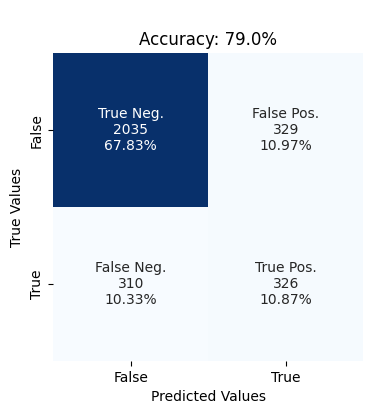

In [808]:
show_cm(y_test,y_pred)

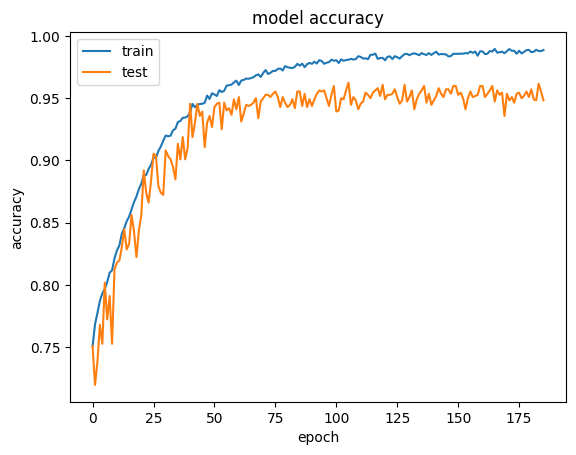

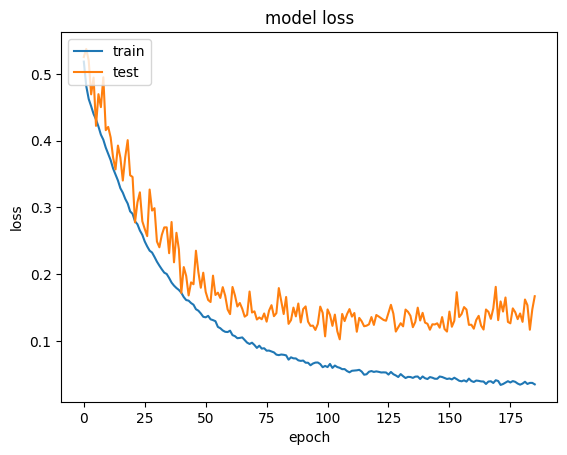

In [809]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">
<h4><center>Należy zwrócić uwagę, że powyższe wyniki uzależnione są każdorazowo od sposobu podziału danych na treningowe i walidacyjne, dlatego wybór konkretnego modelu powinien być podyktowany wielokrotnym dopasowywaniem i porównywaniem wyników.</center></h4>
    <h3 align="left"><a id = "R5">Wnioski:</a></h3>
    <ol>
        <li>Otrzymane dane są kompletne, bez braków.</li>
        <li>Istnieją ogromne dysproporcje w zmiennej objaśnianej Exited - tylko 20% danych zawiera informacje na temat rezygnacji klientów z usług.</li>
        <li>Ponad 50% rekordów dotyczy klientów z Francji, Niemcy i Hiszpanie stanowią po ok. 25% zasobów.</li>
        <li>Spośród wszystkich klientów w 3 państwach największa liczba osób została utracona w Niemczech, bo aż 8.14%.</li>
        <li>Ponad 3600 rekordów zawiera prawdopodobnie błędną informację o zerowym saldzie konta (tylko dane z Francji i Hiszpanii).</li>
        <li>Najlepsze wyniki zbudowanych modeli otrzymano przy wykorzystaniu wszystkich danych odpowiednio przetransformowanych do rozkładów zbliżonych do rozkładu Gaussa i uzupełnieniu zerowych wartości zmiennej Balance.</li>
        <li>Najlepszą dokładność przewidywania rezygnacji klientów osiągnęły modele RandomForestClassifier - na poziomie ok. 84-85%.</li>
        <li>Model zbudowany w oparciu o dane z Niemiec pozwolił na trafne przewidywanie odejść we Francji i Hiszpanii na poziomie 84%.</li>
        <li>Model zbudowany w oparciu o wszystkie dane pozwolił na trafne przewidywanie na poziomie 85%.</li>
        <li>Zwiększenie liczebności zmiennej objaśnianej Exited metodą SMOTE nie przyniosło zamierzonych efektów w postaci zwiąkszenia dokładności całkowitego przewidywania rezygnacji klientów, natomiast pozwoliło na zwiększenie różnicy pomiędzy prawidłowym i negatywnym typowaniem odejścia klientów ze wskazaniem na wartość prawidłowego typowania rezygnacji.</li>
        <li>Modele uczenia głębokiego zbudowane w oparciu o bibliotekę tensorflow, pomimo wysokiego stopnia doboru parametrów i dokładności uczenia powyżej 95% osiągały każdorazowo gorsze wskaźniki przewidywania wartości testowych niż model zbudowany w oprciu o drzewa losowe.
        
